# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.utils.extmath import randomized_svd
from scipy.linalg import null_space
from scipy.stats import gaussian_kde
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from mpl_toolkits.mplot3d import Axes3D


In [2]:
########## Which dataset
# 0 = Adult
# 1 = Folktables
# 2 = Toy datset comp proxies
#####################
dataset = 2
#####################
if dataset == 0:
  sens_attr = 'marital-status'
  target='income'
  name='adult'
elif dataset==1:
  target = 'income'
  sens_attr = 'sex'
  name='folktables'
elif dataset==2:
  sens_attr='sensitive_attribute'
  target='target'
  name='synthetic'

# Toy dataset compositional proxies

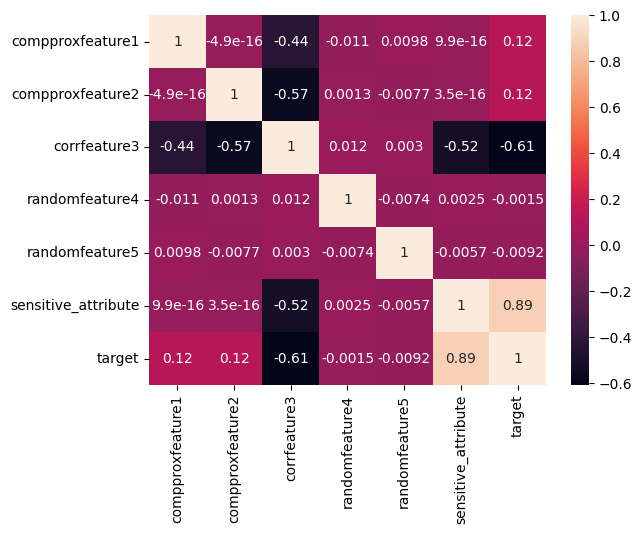

In [3]:
if dataset==2:
  target_var = np.concatenate((np.zeros(5600), np.ones(4400)))
  sensattr = np.concatenate((np.zeros(5000), np.ones(5000)))
  feature1=np.concatenate((np.zeros(2500), np.ones(2500),np.zeros(2500), np.ones(2500)))
  feature2=np.concatenate((np.ones(2500), np.zeros(2500),np.zeros(2500),np.ones(2500)))
  feature5=np.random.randint(1,101,10000)
  feature4=np.random.randint(1000,20001,10000)
  feature3=np.concatenate((np.zeros(300),np.ones(7000),np.zeros(2700)))

  df = pd.DataFrame({'compproxfeature1':feature1, 'compproxfeature2':feature2, 'corrfeature3':feature3, 'randomfeature4':feature4, 'randomfeature5':feature5,
                     'sensitive_attribute':sensattr,
                     'target':target_var})
  corr_matrix = df.corr()
  sns.heatmap(corr_matrix, annot=True)
  plt.show()

# Dataset Folktables download & preparation


In [4]:
if dataset == 1:
  %pip install folktables
  # load data manually from https://www2.census.gov/programs-surveys/acs/data/pums/2014/1-Year/ if not working
  # file name: csv_ptx
  from folktables import ACSDataSource, ACSIncome

  #Load the dataset
  data_source = ACSDataSource(survey_year='2014', horizon='1-Year', survey='person')
  ca_data = data_source.get_data(states=["TX"], download=True)
  features, label, _ = ACSIncome.df_to_pandas(ca_data)

  features = features.rename(columns={
      'AGEP': 'age',
      'COW': 'workclass',
      'SCHL': 'education',
      'MAR': 'marital-status',
      'OCCP': 'occupation',
      'RAC1P': 'race',
      'SEX': 'sex',
      'WKHP': 'hours-per-week'
  })
  f = features[['workclass', 'education', 'marital-status', 'occupation', 'race', 'sex','age', 'hours-per-week']]



  # Target variable
  f['income'] = label
  df=f
  df['sex']=df['sex'].astype(int)
  df.head()

In [5]:
if dataset==1:
  marital_status_map = {
      1:"Married ",
      2:"Widowed",
      3:"Divorced",
      4:"Separated",
      5:"Never Married or Under 15"
  }
  df['marital-status'] = df['marital-status'].replace(marital_status_map)


# Adult dataset download and preparation

In [6]:

# Load dataset
if dataset == 0:
  url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
  column_names = ["age", "workclass", "fnlwgt", "education", "education-num", "marital-status",
      "occupation", "relationship", "race", "sex", "capital-gain", "capital-loss",
      "hours-per-week", "native-country", "income"]

  df = pd.read_csv(url, header=None, names=column_names, na_values='?', skipinitialspace=True)
  print(df.shape)

In [7]:
if dataset==0:
  marital_status_labels = {
      'Married-civ-spouse': 'Married (Civilian Spouse)',
      'Married-AF-spouse': 'Married (Armed Forces Spouse)',
      'Married-spouse-absent': 'Married (Spouse Absent)',
      'Widowed': 'Widowed',
      'Divorced': 'Divorced',
      'Separated': 'Separated',
      'Never-married': 'Never Married'
  }

  relationship_labels = {
      'Husband': 'Husband',
      'Wife': 'Wife',
      'Own-child': 'Own Child',
      'Not-in-family': 'Not in Family',
      'Other-relative': 'Other Relative',
      'Unmarried': 'Unmarried'
  }

  df['marital-status'] = df['marital-status'].map(marital_status_labels)
  df['relationship'] = df['relationship'].map(relationship_labels)


# Data depiction and preprocessing

In [8]:
df.dropna(inplace=True)

################introduce random subsample for testing purposees
df=df.sample(n=10000, random_state=42)
#################

In [9]:
column_names = df.columns
print("Features:\n", column_names)

Features:
 Index(['compproxfeature1', 'compproxfeature2', 'corrfeature3',
       'randomfeature4', 'randomfeature5', 'sensitive_attribute', 'target'],
      dtype='object')


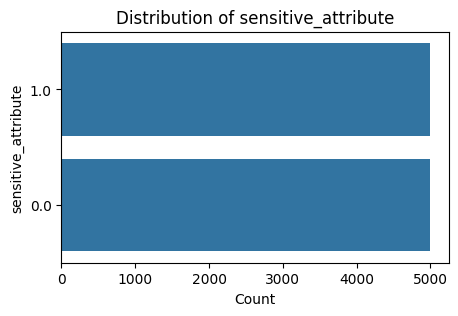

In [10]:
plt.figure(figsize=(5, 3))
sns.countplot(y=sens_attr, data=df, order=df[sens_attr].value_counts().index)
plt.title(f'Distribution of {sens_attr}')
plt.xlabel('Count')
plt.ylabel(sens_attr)
plt.show()


In [11]:
if dataset==1:
  ct=pd.crosstab(df[sens_attr],df['education'])
  ct=np.array(ct)
  print(ct.T)
  fig, ax = plt.subplots(2,1, figsize=(5,8))
  sns.countplot(df, x='education', hue=sens_attr,ax=ax[0])
  ax[0].set_xlabel('education degree')
  plt.setp(ax[0].get_xticklabels(), rotation=90, ha="right",
         rotation_mode="anchor")
  ax[0].set_title('Number of individual\'s education degree by sex')

  sns.barplot((ct.T[:,0]-ct.T[:,1])/(ct.T[:,0]+ct.T[:,1]),ax=ax[1])
  ax[1].set_title('Prop. differences of individual\'s education by sex')
  ax[1].set_xlabel('education degree ')
  ax[1].set_ylabel('Proportional number differences')
  plt.tight_layout()
  plt.savefig('edu_sex.png')
  plt.show()


In [12]:
if dataset==0:
  # Crosstab between marital status and income
  marital_income = pd.crosstab(df['marital-status'], df['income'])
  print(marital_income,"\n")
  marital_sex = pd.crosstab(df['marital-status'], df['sex'])
  print(marital_sex)
  sumf = int(len(df['sex'])) - int(len(df['sex'][df['sex']=='Male']))
  # Plot the distribution of marital status by income
  plt.figure(figsize=(10, 6))
  sns.countplot(x='marital-status', hue='relationship', data=df)
  plt.xticks(rotation=45)
  plt.title('Marital Status Distribution by relationship')
  plt.show()

In [13]:
ndf=df.copy()
if dataset != 2:
  # Convert categorical variables to numerical using Label Encoding
  categorical_columns = df.select_dtypes(include=['object']).columns
  label_encoders = {}

  for col in categorical_columns:
      le = LabelEncoder()
      ndf[col] = le.fit_transform(df[col])
      label_encoders[col] = le
      print(le.classes_)

  #make marital-stauts binary
  ndf.loc[((0 < ndf["marital-status"]) & (ndf["marital-status"]<= 3)), "marital-status"]=1
  ndf.loc[ndf["marital-status"] >3, "marital-status"]=0


#ordering relationship status approrpiately
if dataset==0:
  sns.countplot(ndf, x='relationship', hue='marital-status')
  plt.show()

  counts=np.zeros(6)
  for i in range(6):
    counts[i]=ndf["marital-status"][ndf["relationship"]==i].sum()
  print(counts)
  counts_ind = np.argsort(counts)
  print(counts_ind)
  for i in range(6):
    ndf.loc[ndf["relationship"]==counts_ind[i], ['relationship']]=i-6
  ndf['relationship']=ndf['relationship']+6

  sns.countplot(ndf, x='relationship', hue='marital-status')
  plt.show()

#Creating data splits from data frame
X=ndf.drop(target, axis=1)
y=ndf[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

numerical_columns = X.select_dtypes(include=['int64', 'float64']).columns


In [14]:
# Stroing feature names of X_train for convenience
attributes= np.array(column_names)
#['workclass', 'education', 'marital-status', 'occupation', 'race', 'sex','age', 'hours-per-week','income']
attributes= np.array(column_names)
attributes=attributes[attributes!=sens_attr]
attributes=attributes[attributes!=target]


In [15]:
if dataset==0:
  # Plot distribution of marital status
  plt.figure(figsize=(5, 3))
  sns.countplot(y='marital-status', data=ndf, order=ndf['marital-status'].value_counts().index)
  plt.title('Distribution of Marital Status')
  plt.xlabel('Count')
  plt.yticks([0,1,2],['Married','Not Married',''])
  plt.ylabel('Marital Status')
  plt.show()

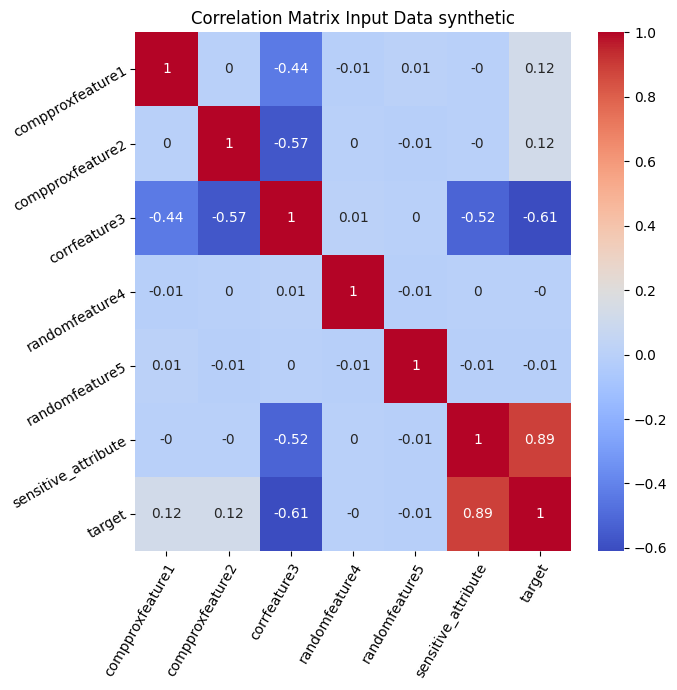

In [16]:
# Correlation matrix
corr_matrix = round(ndf.corr(),2)
fig, ax=plt.subplots(figsize=(7, 7))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm',ax=ax)
plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor")
plt.setp(ax.get_yticklabels(), rotation=30, ha="right",
         rotation_mode="anchor")
ax.set_title(f'Correlation Matrix Input Data {name}')
fig.tight_layout()
plt.savefig(f'corr_matrix_{name}.png')
plt.show()

In [17]:
if dataset==0:
  column_names = ndf.columns
  for a in column_names[0:-1]:
    b=np.corrcoef(X_train["marital-status"], X_train[a])[0,1]
    print(f" {a} has corrcoef: {b:.3f} ")

In [18]:
# Normalize Data
scaler = StandardScaler()
protected_attribute_train = X_train[sens_attr]
protected_attribute_test = X_test[sens_attr]
X_train = X_train.drop(sens_attr, axis=1)
X_test = X_test.drop(sens_attr, axis=1)

numerical_columns = X_train.select_dtypes(include=['int64', 'float64']).columns
X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

# Display the first few rows of the preprocessed DataFrame
#print(X_train.head())
#print(y_train.head())

# Functions for INLP and Encoder-Decoder Model

In [19]:
###### Build Example encoder
#### Train the model
def train_model(X, y, epochs=50, batch_size=64, val_split=0.1, latent_space=8):
# Define the neural network model for binary classification
    model = Sequential([
        Dense(latent_space*8, activation='relu', input_shape=(X.shape[1],)),
        Dropout(0.2),
        Dense(latent_space*4, activation='relu'),
        Dropout(0.2),
        Dense(latent_space*2, activation='relu'),
        Dropout(0.2),
        Dense(latent_space, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    tf.random.set_seed(42)
    history = model.fit(
        X, y,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=val_split,
        verbose=1,
    )
    # Plot training history
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()
    return model

def get_encoder(input, last_layer):
      return Model(inputs=input, outputs=last_layer)

#### Evaluate model
def evaluate_model(model, X, y):
    y_pred_prob = model.predict(X)
    y_pred = (y_pred_prob > 0.5).astype(int)  # get predictions

    # Calculate accuracy and print classification report
    accuracy = accuracy_score(y, y_pred)
    print(f"Test Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y, y_pred))



In [20]:

def define_decoder(X):
    # Define the decoder
    # Get the encoded features for the training and test sets
    encoded_X_train = X.copy()
    input=encoded_X_train.shape[1]
    decoder_input = Input(shape=(input,))
    decoder_layer1 = Dense(input*2, activation='relu')(decoder_input)
    decoder_dropout1 = Dropout(0.2)(decoder_layer1)
    decoder_layer2 = Dense(input*4, activation='relu')(decoder_dropout1)
    decoder_dropout2 = Dropout(0.2)(decoder_layer2)
    decoder_layer3 = Dense(input*8, activation='relu')(decoder_dropout2)
    decoder_output = Dense(X_train.shape[1], activation='linear')(decoder_layer3)

    decoder = Model(decoder_input, decoder_output)

    decoder.compile(optimizer='adam', loss='mse')

    decoder.summary()
    return decoder

In [21]:
# an abstract class for linear classifiers
# this code is imported from the paper Ravfogel et. al (2020), "Null It Out: Guarding Protected Attributes by Iterative Nullspace Projection"
class Classifier(object):

    def __init__(self):

        pass

    def train(self, X_train: np.ndarray, Y_train: np.ndarray, X_dev: np.ndarray, Y_dev: np.ndarray) -> float:
        """

        :param X_train:
        :param Y_train:
        :param X_dev:
        :param Y_dev:
        :return: accuracy score on the dev set
        """
        raise NotImplementedError

    def get_weights(self) -> np.ndarray:
        """
        :return: final weights of the model, as np array
        """

        raise NotImplementedError




class SKlearnClassifier(Classifier):

    def __init__(self, m):

        self.model = m

    def train_network(self, X_train: np.ndarray, Y_train: np.ndarray, X_dev: np.ndarray, Y_dev: np.ndarray) -> float:

        """
        :param X_train:
        :param Y_train:
        :param X_dev:
        :param Y_dev:
        :return: accuracy score on the dev set / Person's R in the case of regression
        """

        self.model.fit(X_train, Y_train)
        score = self.model.score(X_dev, Y_dev)
        return score

    def get_weights(self) -> np.ndarray:
        """
        :return: final weights of the model, as np array
        """

        w = self.model.coef_
        if len(w.shape) == 1:
                w = np.expand_dims(w, 0)

        return w

In [22]:
# this code is imported from the paper Ravfogel et. al (2020), "Null It Out: Guarding Protected Attributes by Iterative Nullspace Projection"

from typing import Dict
import numpy as np
import scipy
from typing import List
from tqdm import tqdm
import random
import warnings


def get_rowspace_projection(W: np.ndarray) -> np.ndarray:
    """
    :param W: the matrix over its nullspace to project
    :return: the projection matrix over the rowspace
    """

    if np.allclose(W, 0):
        w_basis = np.zeros_like(W.T)
    else:
        w_basis = scipy.linalg.orth(W.T) # orthogonal basis

    P_W = w_basis.dot(w_basis.T) # orthogonal projection on W's rowspace

    return P_W

def get_projection_to_intersection_of_nullspaces(rowspace_projection_matrices: List[np.ndarray], input_dim: int):
    """
    Given a list of rowspace projection matrices P_R(w_1), ..., P_R(w_n),
    this function calculates the projection to the intersection of all nullspasces of the matrices w_1, ..., w_n.
    uses the intersection-projection formula of Ben-Israel 2013 http://benisrael.net/BEN-ISRAEL-NOV-30-13.pdf:
    N(w1)∩ N(w2) ∩ ... ∩ N(wn) = N(P_R(w1) + P_R(w2) + ... + P_R(wn))
    :param rowspace_projection_matrices: List[np.array], a list of rowspace projections
    :param dim: input dim
    """

    I = np.eye(input_dim)
    Q = np.sum(rowspace_projection_matrices, axis = 0)
    P = I - get_rowspace_projection(Q)

    return P

def debias_by_specific_directions(directions: List[np.ndarray], input_dim: int):
    """
    the goal of this function is to perform INLP on a set of user-provided directions (instead of learning those directions).
    :param directions: list of vectors, as numpy arrays.
    :param input_dim: dimensionality of the vectors.
    """

    rowspace_projections = []

    for v in directions:
        P_v = get_rowspace_projection(v)
        rowspace_projections.append(P_v)

    P = get_projection_to_intersection_of_nullspaces(rowspace_projections, input_dim)

    return P


def get_debiasing_projection(classifier_class, cls_params: Dict, num_classifiers: int, input_dim: int,
                             is_autoregressive: bool,
                             min_accuracy: float, X_train: np.ndarray, Y_train: np.ndarray, X_dev: np.ndarray,
                             Y_dev: np.ndarray, by_class=False, Y_train_main=None,
                             Y_dev_main=None, dropout_rate = 0) -> np.ndarray:
    """
    :param classifier_class: the sklearn classifier class (SVM/Perceptron etc.)
    :param cls_params: a dictionary, containing the params for the sklearn classifier
    :param num_classifiers: number of iterations (equivalent to number of dimensions to remove)
    :param input_dim: size of input vectors
    :param is_autoregressive: whether to train the ith classiifer on the data projected to the nullsapces of w1,...,wi-1
    :param min_accuracy: above this threshold, ignore the learned classifier
    :param X_train: ndarray, training vectors
    :param Y_train: ndarray, training labels (protected attributes)
    :param X_dev: ndarray, eval vectors
    :param Y_dev: ndarray, eval labels (protected attributes)
    :param by_class: if true, at each iteration sample one main-task label, and extract the protected attribute only from vectors from this class
    :param T_train_main: ndarray, main-task train labels
    :param Y_dev_main: ndarray, main-task eval labels
    :param dropout_rate: float, default: 0 (note: not recommended to be used with autoregressive=True)
    :return: P, the debiasing projection; rowspace_projections, the list of all rowspace projection; Ws, the list of all classifiers.
    """
    if dropout_rate > 0 and is_autoregressive:
        warnings.warn("Note: when using dropout with autoregressive training, the property w_i.dot(w_(i+1)) = 0 no longer holds.")

    I = np.eye(input_dim)

    if by_class:
        if ((Y_train_main is None) or (Y_dev_main is None)):
            raise Exception("Need main-task labels for by-class training.")
        main_task_labels = list(set(Y_train_main.tolist()))

    X_train_cp = X_train.copy()
    X_dev_cp = X_dev.copy()
    rowspace_projections = []
    Ws = []

    pbar = tqdm(range(num_classifiers))
    for i in pbar:

        clf = SKlearnClassifier(classifier_class(**cls_params))
        dropout_scale = 1./(1 - dropout_rate + 1e-6)
        dropout_mask = (np.random.rand(*X_train.shape) < (1-dropout_rate)).astype(float) * dropout_scale


        if by_class:
            #cls = np.random.choice(Y_train_main)  # uncomment for frequency-based sampling
            cls = random.choice(main_task_labels)
            relevant_idx_train = Y_train_main == cls
            relevant_idx_dev = Y_dev_main == cls
        else:
            relevant_idx_train = np.ones(X_train_cp.shape[0], dtype=bool)
            relevant_idx_dev = np.ones(X_dev_cp.shape[0], dtype=bool)

        acc = clf.train_network((X_train_cp * dropout_mask)[relevant_idx_train], Y_train[relevant_idx_train], X_dev_cp[relevant_idx_dev], Y_dev[relevant_idx_dev])
        pbar.set_description("iteration: {}, accuracy: {}".format(i, acc))
        print(acc)
        if acc < min_accuracy: continue

        W = clf.get_weights()
        Ws.append(W)
        P_rowspace_wi = get_rowspace_projection(W) # projection to W's rowspace
        rowspace_projections.append(P_rowspace_wi)

        if is_autoregressive:

            """
            to ensure numerical stability, explicitly project to the intersection of the nullspaces found so far (instaed of doing X = P_iX,
            which is problematic when w_i is not exactly orthogonal to w_i-1,...,w1, due to e.g inexact argmin calculation).
            """
            # use the intersection-projection formula of Ben-Israel 2013 http://benisrael.net/BEN-ISRAEL-NOV-30-13.pdf:
            # N(w1)∩ N(w2) ∩ ... ∩ N(wn) = N(P_R(w1) + P_R(w2) + ... + P_R(wn))

            P = get_projection_to_intersection_of_nullspaces(rowspace_projections, input_dim)
            # project

            X_train_cp = (P.dot(X_train.T)).T
            X_dev_cp = (P.dot(X_dev.T)).T

    """
    calculate final projection matrix P=PnPn-1....P2P1
    since w_i.dot(w_i-1) = 0, P2P1 = I - P1 - P2 (proof in the paper); this is more stable.
    by induction, PnPn-1....P2P1 = I - (P1+..+PN). We will use instead Ben-Israel's formula to increase stability and also generalize to the non-orthogonal case (e.g. with dropout),
    i.e., we explicitly project to intersection of all nullspaces (this is not critical at this point; I-(P1+...+PN) is roughly as accurate as this provided no dropout & regularization)
    """

    P = get_projection_to_intersection_of_nullspaces(rowspace_projections, input_dim)

    return P, rowspace_projections, Ws


In [23]:
# Train the decoder
def train_decoder(X, projected_outputs, epochs=50, batch_size=64, val_split=0.2):
    decoder=define_decoder(projected_outputs)
    decoder.compile(optimizer='adam', loss='mse')
    # Train the decoder
    history_decoder_inlp = decoder.fit(
        projected_outputs, X,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=val_split,
        verbose=1
    )

    plt.plot(range(1,epochs+1),history_decoder_inlp.history['loss'], label='Training Loss')
    plt.plot(range(1,epochs+1),history_decoder_inlp.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    return decoder

In [24]:
# this code is imported from the paper Ravfogel et. al (2020), "Null It Out: Guarding Protected Attributes by Iterative Nullspace Projection"
def train_classifier(X, Z):
    """
    Train a classifier to predict the protected attributes Z from the data X.

    Args:
        X: Input data of shape (num_samples, num_features).
          -> here use the encoded features
        Z: Protected attributes of shape (num_samples, num_protected_attributes).

    Returns:
        W: The weight matrix of the trained classifier.
    """
    # Use logistic regression as the classifier
    classifier = LogisticRegression()
    classifier.fit(X,Z)
    print('accuracy of logistic classifier:', classifier.score(X,Z))
    # Return the weight matrix (coefficients) of the classifier
    return classifier.coef_.T  # Shape: (num_features, num_protected_attributes)

def iterative_nullspace_projection(X, Y, n_rounds=10):
    from sklearn.linear_model import SGDClassifier, Perceptron, LogisticRegression
    d = X.shape[1]
    num_classifiers = n_rounds
    classifier_class = LogisticRegression
    input_dim = d
    is_autoregressive = True
    min_accuracy = 0.0

    P, rowspace_projections, Ws = get_debiasing_projection(classifier_class, {}, num_classifiers, input_dim, is_autoregressive, min_accuracy, X, Y, X, Y, by_class = False)

    I = np.eye(P.shape[0])
    P_alternative = I - np.sum(rowspace_projections, axis = 0)
    P_by_product = I.copy()

    for P_Rwi in rowspace_projections:

        P_Nwi = I - P_Rwi
        P_by_product = P_Nwi.dot(P_by_product)


    #testing

    # validate that P = PnPn-1...P2P1 (should be true only when w_i.dot(w_(i+1)) = 0, in autoregressive training)

    if is_autoregressive:
        assert np.allclose(P_alternative, P)
        assert np.allclose(P_by_product, P)

    # validate that P is a projection

    assert np.allclose(P.dot(P), P)

    # validate that P projects to N(w1)∩ N(w2) ∩ ... ∩ N(wn)

    x = np.random.rand(d) - 0.5
    for w in Ws:

        assert np.allclose(np.linalg.norm(w.dot(P.dot(x))), 0.0)

    # validate that each two classifiers are orthogonal (this is expected to be true only with autoregressive training)

    if is_autoregressive:
        for i,w in enumerate(Ws):

            for j, w2 in enumerate(Ws):

                if i == j: continue

                assert np.allclose(np.linalg.norm(w.dot(w2.T)), 0)

    return P



In [25]:
def get_inlp(encoder_outputs, protected_attribute, n_rounds):
    # Perform INLP
    P = iterative_nullspace_projection(encoder_outputs, protected_attribute, n_rounds=n_rounds)
    return P

In [26]:
# extract last layer/input
def get_encoder_output(model):
    return model.layers[-2].output
def get_encoder_input(model):
    return model.layers[0].input


# Test Pipeline INLP Enc-Dec Model

In [27]:
########### Necessary Data input
only_inlp_change=False
if only_inlp_change ==  False:
  X_train= X_train
  y_train = y_train
  X_test= X_test
  y_test = y_test
  protected_attribute_test = protected_attribute_test
  protected_attribute_train = protected_attribute_train
###########


In [28]:
############# Hyperparameter INLP
num_iterations = 5
latent_space= 8
#############

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,137 (12.25 KB)

 Trainable params: 3,137 (12.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 16s 55ms/step - accuracy: 0.7176 - loss: 0.5582 - val_accuracy: 0.9438 - val_loss: 0.1461
Epoch 2/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9315 - loss: 0.1698 - val_accuracy: 0.9438 - val_loss: 0.1356
Epoch 3/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9368 - loss: 0.1422 - val_accuracy: 0.9438 - val_loss: 0.1353
Epoch 4/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9364 - loss: 0.1384 - val_accuracy: 0.9438 - val_loss: 0.1357
Epoch 5/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9386 - loss: 0.1363 - val_accuracy: 0.9438 - val_loss: 0.1350
Epoch 6/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9388 - loss: 0.1362 - val_accuracy: 0.9438 - val_loss: 0.1348
Epoch 7/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9388 - loss: 0.1351 - val_accuracy: 0.9438 - val_loss: 0.1353
Epoch 8/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9385 - loss: 0.1331 - val_accuracy:

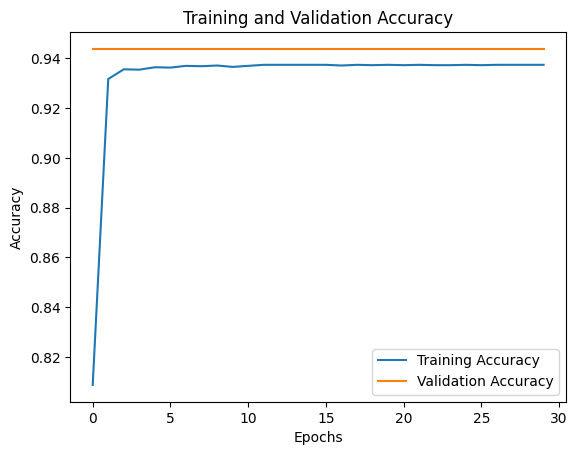

In [29]:
### Train examined model
if only_inlp_change ==  False:
  model = train_model(X_train, y_train, epochs=30, batch_size=64, val_split=0.1, latent_space=latent_space)

In [30]:
evaluate_model(model, X_test,y_test)

# Get model predictions
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype("int32")

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
print("Confusion Matrix:")
print(cm)

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Test Accuracy: 0.9480

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.91      0.95      1117
         1.0       0.89      1.00      0.94       883

    accuracy                           0.95      2000
   macro avg       0.95      0.95      0.95      2000
weighted avg       0.95      0.95      0.95      2000

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Confusion Matrix:
[[1013  104]
 [   0  883]]


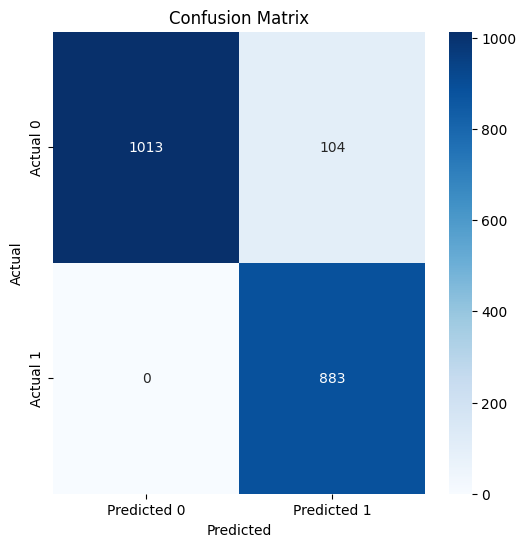

In [31]:
# Visualize the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

In [32]:
### Trained parameters
encoded_data = get_encoder_output(model)
encoder = get_encoder(get_encoder_input(model), encoded_data)


# Get the output of last layer as a NumPy array
encoder_outputs_train = encoder.predict(X_train)
encoder_outputs_test = encoder.predict(X_test)

# inlp projection of encoded data
inlp_matrix = get_inlp(encoder_outputs_train, protected_attribute_train, num_iterations)

# Project the data onto the null space
X_projected = (inlp_matrix @ encoder_outputs_test.T).T
X_projected_train = (inlp_matrix @ encoder_outputs_train.T).T



250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


iteration: 2, accuracy: 1.0:   0%|          | 0/5 [00:00<?, ?it/s]

1.0
1.0
1.0


iteration: 3, accuracy: 0.878:  80%|████████  | 4/5 [00:00<00:00, 35.64it/s]

0.878


iteration: 4, accuracy: 0.639875: 100%|██████████| 5/5 [00:00<00:00, 36.61it/s]

0.639875


Testing model accuracy after cleaning the data with inlp:

In [33]:
X_projected = (inlp_matrix @ encoder_outputs_test.T).T
X_projected_train = (inlp_matrix @ encoder_outputs_train.T).T

# Check accuracy of inp reconstruction for target
log=LogisticRegression()
log.fit(X_projected_train, y_train)
print('Accuracy of predicting y from inlp_projected X: ',log.score(X_projected, y_test))
print('majority vote result:', 1-y_test.sum()/len(y_test))

# Check if inlp reconstruction allows for predicting sens attr a
log=LogisticRegression()
log.fit(X_projected_train, protected_attribute_train)
print('Accuracy of predicting a from inlp_projected X: ', log.score(X_projected, protected_attribute_test))
print('majority vote result:', 1-protected_attribute_test.sum()/len(protected_attribute_test))

# Get the accuracy of the original datasets prediction for the sens attr
log=LogisticRegression()
log.fit(X_train, protected_attribute_train)
print('Accuracy of predicting a from X: ', log.score(X_test, protected_attribute_test))

Accuracy of predicting y from inlp_projected X:  0.6945
majority vote result: 0.5585
Accuracy of predicting a from inlp_projected X:  0.617
majority vote result: 0.5065
Accuracy of predicting a from X:  0.9745


How impactful are the features changed by the inlp matrix:

In [34]:
print("The weights sorted by the differences introduced by the cleaning process + change strength:\n",
      np.round(np.stack((np.array(model.weights[-2].value)[np.argsort(-np.mean(X_projected - encoder_outputs_test,axis=0)**2)].flatten(),-np.sort(-np.mean(X_projected - encoder_outputs_test,axis=0)**2)),axis=1),3))

The weights sorted by the differences introduced by the cleaning process + change strength:
 [[-1.038 43.716]
 [-1.039 38.963]
 [ 0.916 10.088]
 [-0.271  9.839]
 [ 0.611  4.036]
 [ 0.848  2.125]
 [ 0.072  0.702]
 [ 0.445  0.   ]]


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,125 (12.21 KB)

 Trainable params: 3,125 (12.21 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.1952 - val_loss: 0.7174
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7619 - val_loss: 0.6613
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6863 - val_loss: 0.6278
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6543 - val_loss: 0.6124
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6358 - val_loss: 0.5927
Epoch 6/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6100 - val_loss: 0.5520
Epoch 7/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5776 - val_loss: 0.5085
Epoch 8/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5445 - val_loss: 0.4888
Epoch 9/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5214 - val_loss: 0.4820
Epoch 10/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5088 - val_loss: 0.4799
Epoch 11/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.4889 - val_loss: 0.4780
Epoch 12/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

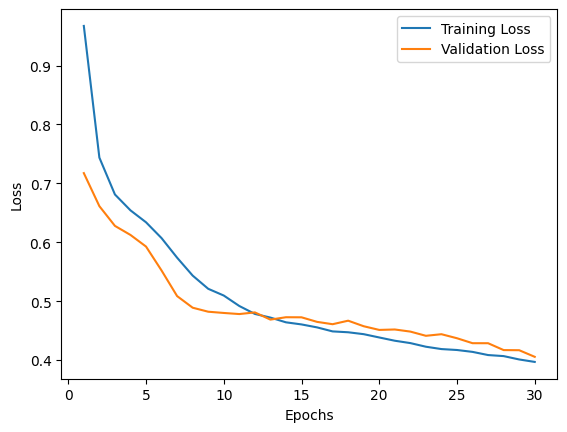

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [35]:
#### decoder
#decoder = define_decoder(encoder_outputs_train)
if False == only_inlp_change:
  decoder_trained = train_decoder(X_train, encoder_outputs_train, epochs=30)

# Reconstruct the test set

  reconstructed_X_test = decoder_trained.predict(encoder_outputs_test)


# Reconstruct the test set
reconstructed_X_test_inlp_old = decoder_trained.predict(X_projected)



In [36]:
#original data corrrelation to pa
b=np.zeros_like(attributes)
for (a, i) in zip(attributes, range(len(attributes))):
  b[i]=abs(np.corrcoef(protected_attribute_test, X_test[a])[0,1])
  print(f" {a} has corrcoef: {float(b[i]):.3f} with a in X_test")
arg=np.argmax(b)
b=np.nan_to_num(b,nan=0)
print(f"\n max correlation is {attributes[arg]}: {float(b[arg]):.3f}")

 compproxfeature1 has corrcoef: 0.014 with a in X_test
 compproxfeature2 has corrcoef: 0.013 with a in X_test
 corrfeature3 has corrcoef: 0.553 with a in X_test
 randomfeature4 has corrcoef: 0.001 with a in X_test
 randomfeature5 has corrcoef: 0.006 with a in X_test

 max correlation is corrfeature3: 0.553


In [37]:
# normal reconstruction correlation to pa
b2=np.zeros_like(attributes, dtype='float')
for (a, i) in zip(attributes, range(len(attributes))):
  b2[i]=abs(np.corrcoef(protected_attribute_test, reconstructed_X_test[:,i])[0,1])
  print(f" {a} has corrcoef: {float(b2[i]):.3f} in X_test")
b2 = np.nan_to_num(b2,nan=0)
arg=np.argmax(b2)
print(f"\n max correlation is {attributes[arg]}: {float(b2[arg]):.3f}")

 compproxfeature1 has corrcoef: 0.175 in X_test
 compproxfeature2 has corrcoef: 0.056 in X_test
 corrfeature3 has corrcoef: 0.570 in X_test
 randomfeature4 has corrcoef: 0.085 in X_test
 randomfeature5 has corrcoef: 0.427 in X_test

 max correlation is corrfeature3: 0.570


In [38]:
#inlp (same decoder) reconstruction correlation to pa
b4=np.zeros_like(attributes, dtype='float')
for (a, i) in zip(attributes, range(len(attributes))):
  b4[i]=abs(np.corrcoef(protected_attribute_test, reconstructed_X_test_inlp_old[:,i])[0,1])
  print(f" {a} has corrcoef: {float(b4[i]):.3f} with a in X_test")
b4 = np.nan_to_num(b4,nan=0)
arg=np.argmax(b4)
print(f"\n max correlation is {attributes[arg]}: {float(b4[arg]):.3f}")

 compproxfeature1 has corrcoef: 0.643 with a in X_test
 compproxfeature2 has corrcoef: 0.622 with a in X_test
 corrfeature3 has corrcoef: 0.619 with a in X_test
 randomfeature4 has corrcoef: 0.632 with a in X_test
 randomfeature5 has corrcoef: 0.652 with a in X_test

 max correlation is randomfeature5: 0.652


In [39]:
# Calculate reconstruction error (MRE), using same decoder
reconstruction_error = np.mean(np.square(X_test - reconstructed_X_test),axis=0)
print(f"\n Mean Reconstruction Error (MRE): {np.mean(reconstruction_error):.4f}")
print(f"\n TOP 3 Highest Reconstruction Error (MRE) of one attribute are: {np.sort(reconstruction_error)[-3:]} is {attributes[np.array(np.argsort(reconstruction_error)[-3:])]}")

# Calculate reconstruction error (MRE) of INLP
reconstruction_error_inlp = np.mean(np.square(X_test - reconstructed_X_test_inlp_old),axis=0)
print(f"\n Mean Reconstruction Error (MRE) w INLP: {np.mean(reconstruction_error_inlp):.4f}")
print(f"\n TOP 3 Highest Reconstruction Error (MRE) w INLP of one attriute are: {np.sort(reconstruction_error_inlp)[-3:]} is {attributes[np.array(np.argsort(reconstruction_error_inlp)[-3:])]}")
# diff:

#biggest difference in reconstruction
rec_diff= reconstruction_error_inlp-reconstruction_error
for a,b,c in zip(attributes,rec_diff, reconstruction_error):
  print(f'{a}:    reconstruction diff:{b:.3f}, Rec_error:{c:.3f}')
print(f"\n TOP 3 Highest Reconstruction Error (MRE) difference of one attriute are: {np.sort(rec_diff)[-3:]} is {attributes[np.array(np.argsort(rec_diff)[-3:])]}")


 Mean Reconstruction Error (MRE): 0.4068

 TOP 3 Highest Reconstruction Error (MRE) of one attribute are: [0.10227322 0.86144828 0.98850339] is ['compproxfeature1' 'randomfeature4' 'randomfeature5']

 Mean Reconstruction Error (MRE) w INLP: 1.7258

 TOP 3 Highest Reconstruction Error (MRE) w INLP of one attriute are: [1.31822181 1.5295861  3.57024899] is ['compproxfeature1' 'randomfeature4' 'corrfeature3']
compproxfeature1:    reconstruction diff:1.216, Rec_error:0.102
compproxfeature2:    reconstruction diff:1.165, Rec_error:0.045
corrfeature3:    reconstruction diff:3.533, Rec_error:0.037
randomfeature4:    reconstruction diff:0.668, Rec_error:0.861
randomfeature5:    reconstruction diff:0.013, Rec_error:0.989

 TOP 3 Highest Reconstruction Error (MRE) difference of one attriute are: [1.16472541 1.21594859 3.53337772] is ['compproxfeature2' 'compproxfeature1' 'corrfeature3']


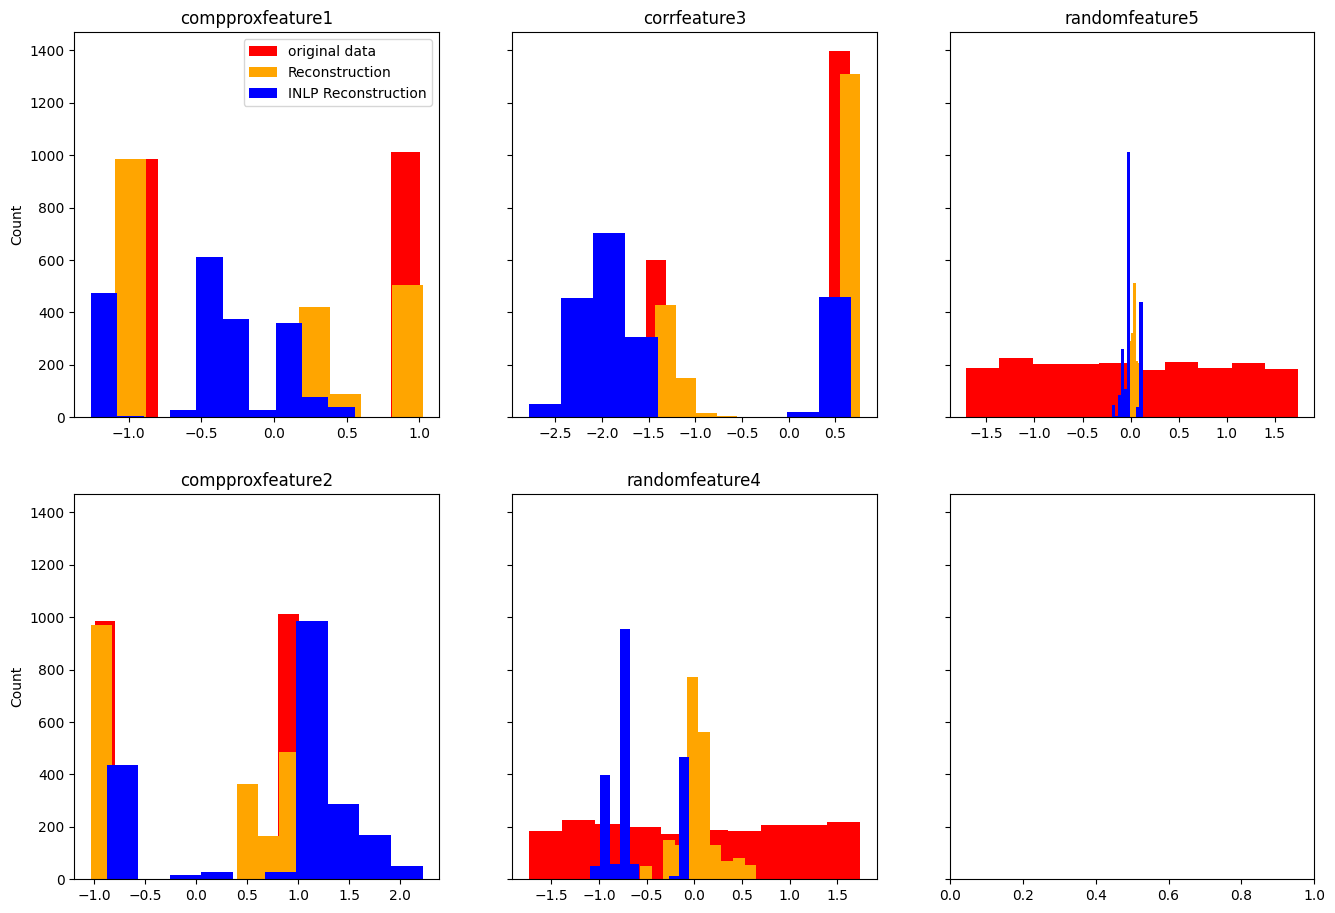

In [40]:
# Compare reconstructions of features in distriution with original
t=2
fig,plot=plt.subplots(t,len(attributes)//t+1, figsize=(16, 11),sharex=False,sharey=True)
for s in range(len(attributes)):
  plot[s%t,s//t].hist(X_test[attributes[s]], color='red',label='original data')
  plot[s%t,s//t].hist(reconstructed_X_test[:,s],color='orange', label= 'Reconstruction')
  plot[s%t,s//t].hist(reconstructed_X_test_inlp_old[:,s],color='blue', label='INLP Reconstruction')
  plot[s%t,s//t].set_title(attributes[s])
  if s==0:
    plot[s//t,s%t].legend()
  if s%t==2:
    plot[s%t,s//t].set_xlabel('Value')
  if s//t==0:
    plot[s%t,s//t].set_ylabel('Count')
plt.savefig(f'reconstruction_comparison_{name}.png')
plt.show()

['randomfeature5' 'randomfeature4' 'compproxfeature2']


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 64)             │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,073 (12.00 KB)

 Trainable params: 3,073 (12.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.6966 - loss: 0.5828 - val_accuracy: 0.9400 - val_loss: 0.1556
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9352 - loss: 0.1725 - val_accuracy: 0.9400 - val_loss: 0.1448
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9415 - loss: 0.1425 - val_accuracy: 0.9400 - val_loss: 0.1457
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9412 - loss: 0.1410 - val_accuracy: 0.9400 - val_loss: 0.1455
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9425 - loss: 0.1380 - val_accuracy: 0.9400 - val_loss: 0.1457
Epoch 6/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9428 - loss: 0.1362 - val_accuracy: 0.9400 - val_loss: 0.1456
Epoch 7/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9425 - loss: 0.1360 - val_accuracy: 0.9400 - val_loss: 0.1459
Epoch 8/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9428 - loss: 0.1355 - val_accuracy: 0.

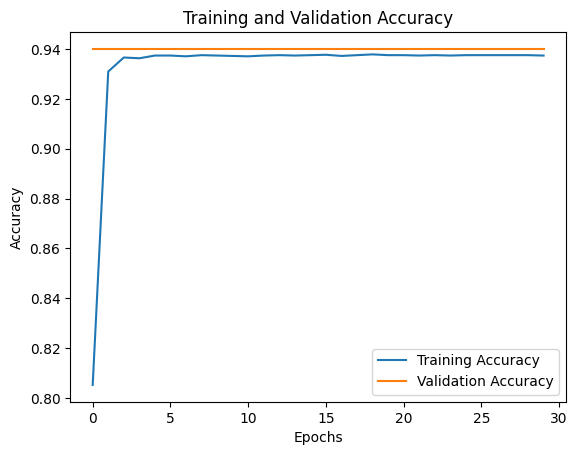

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Test Accuracy: 0.9480

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.91      0.95      1117
         1.0       0.89      1.00      0.94       883

    accuracy                           0.95      2000
   macro avg       0.95      0.95      0.95      2000
weighted avg       0.95      0.95      0.95      2000



In [41]:
print(attributes[np.argsort(rec_diff)[:-2]])
X_rem=X_train[attributes[np.argsort(rec_diff)[:-1]]]
X_test_rem=X_test[attributes[np.argsort(np.array(rec_diff))][:-1]]
model_test = train_model(X_rem, y_train, epochs=30, batch_size=64, val_split=0.2, latent_space=latent_space)
evaluate_model(model_test, X_test_rem,y_test)


In [42]:
encoded_data_rem = get_encoder_output(model_test)
encoder = get_encoder(get_encoder_input(model_test), encoded_data_rem)
encoder_outputs_rem= encoder.predict(X_rem)
encoder_outputs_rem_test= encoder.predict(X_test_rem)

250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [43]:
print(f"Accuracy of predicting a from X: {log.score(X_test, protected_attribute_test)}")
#Check if the protected attribute is predicatble from reconstructed data
reconstructed_X_train = decoder_trained.predict(encoder_outputs_train)
linearmodel2 = LogisticRegression()
linearmodel2.fit(reconstructed_X_train, protected_attribute_train)
print(f"Accuracy of predicting a from X_reconstructed: {linearmodel2.score(reconstructed_X_test, protected_attribute_test)}")

#Check if the protected attribute is predicatble from reconstructed data with INLP
reconstructed_X_train_inlp = decoder_trained.predict(X_projected_train)
linearmodel3 = LogisticRegression()
linearmodel3.fit(reconstructed_X_train_inlp, protected_attribute_train)
print(f"Accuracy of predicting a from X_reconstructed_INLP: {linearmodel3.score(reconstructed_X_test_inlp_old, protected_attribute_test)}")

#Check if the protected attribute is predicatble from reconstructed data
reconstructed_X_train = decoder_trained.predict(encoder_outputs_rem)
reconstructed_X_test = decoder_trained.predict(encoder_outputs_rem_test)
linearmodel2 = LogisticRegression()
linearmodel2.fit(reconstructed_X_train, protected_attribute_train)
print(f"Accuracy of predicting a from X_reconstructed without having relationship in training: {linearmodel2.score(reconstructed_X_test, protected_attribute_test)}")


#Majority vote ratio
print("Majority vote result:", abs((protected_attribute_test.sum()-len(protected_attribute_test))/len(protected_attribute_test)))

Accuracy of predicting a from X: 0.9745
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Accuracy of predicting a from X_reconstructed: 1.0
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Accuracy of predicting a from X_reconstructed_INLP: 0.65
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy of predicting a from X_reconstructed without having relationship in training: 1.0
Majority vote result: 0.5065


# Data modification as identification tool

In [44]:
def train_model_Pope(X_with_a, X, a, output_space, orgmodel, epochs=20, batch_size=64, val_split=0.2, lc=0.5, lr=0.2):

    class CustomLoss(tf.keras.losses.Loss):
        def __init__(self, lr, lc, a, orgmodel, **kwargs):
            super().__init__(**kwargs)
            self.lr = lr
            self.lc = lc
            self.orgmodel= orgmodel
            self.a = tf.cast(a, tf.float32)

        def call(self, y_true, y_pred):
            @tf.function(input_signature=[tf.TensorSpec(shape=y_pred.shape, dtype=y_pred.dtype)])
            def predict_ys(y_pred):
                return self.orgmodel(y_pred)

            ys = predict_ys(y_true)
            ys_pred = predict_ys(y_pred)
            recon_loss = tf.reduce_mean(tf.square(y_pred - y_true))

            # Independence measure via correlation (approximation)
            corr = tf.reduce_mean(((ys_pred - tf.reduce_mean(ys_pred))/tf.math.reduce_std(ys_pred)) *
                                 ((self.a - tf.reduce_mean(self.a))/tf.math.reduce_std(self.a)))
            independence_loss = tf.square(corr)
            acc_loss = tf.reduce_mean(tf.square(ys_pred - ys))
            return acc_loss + self.lr * recon_loss + self.lc * independence_loss

    model = tf.keras.Sequential([
        tf.keras.layers.Dense(output_space*4, activation='relu', input_shape=(X_with_a.shape[1],)),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(output_space*2, activation='relu'),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(output_space, activation='sigmoid'),
    ])

    model.compile(
        optimizer='adam',
        loss=CustomLoss(lr=lr, lc=lc, a=a, orgmodel=orgmodel),
        metrics=['accuracy']
    )

    history = model.fit(
        X_with_a, X,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=val_split,
        verbose=1,
    )

  # Plot training history (optional)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()
    return model


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_14 (Dense)                │ (None, 64)             │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,137 (12.25 KB)

 Trainable params: 3,137 (12.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7428 - loss: 0.5668 - val_accuracy: 0.9400 - val_loss: 0.1716
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9264 - loss: 0.1882 - val_accuracy: 0.9400 - val_loss: 0.1450
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9367 - loss: 0.1474 - val_accuracy: 0.9400 - val_loss: 0.1433
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9405 - loss: 0.1415 - val_accuracy: 0.9400 - val_loss: 0.1420
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9430 - loss: 0.1324 - val_accuracy: 0.9400 - val_loss: 0.1424
Epoch 6/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9422 - loss: 0.1326 - val_accuracy: 0.9400 - val_loss: 0.1430
Epoch 7/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9404 - loss: 0.1347 - val_accuracy: 0.9400 - val_loss: 0.1429
Epoch 8/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9424 - loss: 0.1306 - val_accuracy: 0.

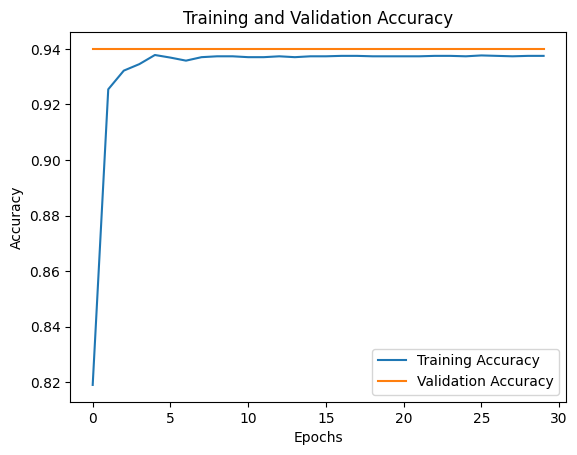

In [45]:
latent_space=8
orgmodel = train_model(X_train, y_train, epochs=30, batch_size=64, val_split=0.2, latent_space=latent_space)

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.3627 - loss: 0.6222 - val_accuracy: 0.4806 - val_loss: 0.6065
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4739 - loss: 0.5561 - val_accuracy: 0.3606 - val_loss: 0.2941
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3763 - loss: 0.2669 - val_accuracy: 0.2969 - val_loss: 0.1909
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3390 - loss: 0.2121 - val_accuracy: 0.2969 - val_loss: 0.1837
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3559 - loss: 0.1996 - val_accuracy: 0.3369 - val_loss: 0.1784
Epoch 6/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3760 - loss: 0.1924 - val_accuracy: 0.3500 - val_loss: 0.1756
Epoch 7/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3879 - loss: 0.1893 - val_accuracy: 0.3762 - val_loss: 0.1710
Epoch 8/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3874 - loss: 0.1850 - val_accuracy: 0.3825 - val

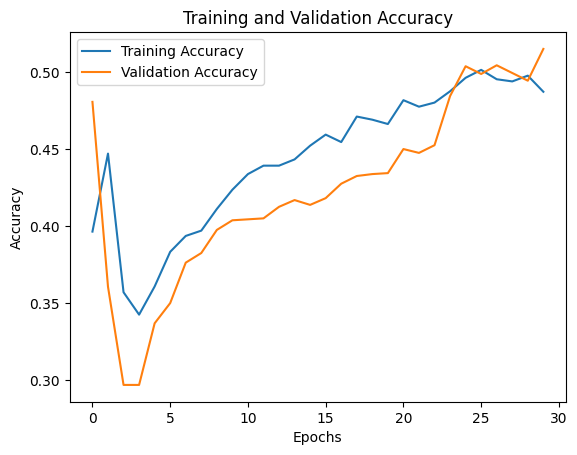

In [46]:
input_shape= get_encoder_input(orgmodel).shape[1]
a=np.array(protected_attribute_train)
X_with_a= np.concatenate((X_train,a.reshape(-1,1)),axis=1)
datamodel= train_model_Pope(X_with_a, X_train, a, input_shape, orgmodel, epochs=30)

In [47]:
a_test=np.array(protected_attribute_test)
test_pred=datamodel.predict(np.concatenate((X_test,a_test.reshape(-1,1)),axis=1))

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


In [48]:
for x in range(len(attributes)):
  print( f"{attributes[np.argsort(-np.mean(np.square(test_pred-X_test),axis=0))][x]} differs from original by {-np.sort(-np.mean(np.square(test_pred-X_test),axis=0))[x]:.3f}")


corrfeature3 differs from original by 0.814
compproxfeature1 differs from original by 0.764
compproxfeature2 differs from original by 0.728
randomfeature5 differs from original by 0.584
randomfeature4 differs from original by 0.580


#Anomaly Detection


In [49]:
#data preparation:
X = ndf.drop(columns=[target])
y = ndf[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)
scaler=StandardScaler()
latent_space=8

#Store sensitive attribute and remove it from data set
y2 = X_train[sens_attr]
X_train=X_train.drop(columns=[sens_attr])
y2_test = X_test[sens_attr]
X_test=X_test.drop(columns=[sens_attr])

if np.sum(y2==0) > np.sum(y2==1):
  y2.loc[y2==1]=2
  y2.loc[y2==0]=1
  y2_test.loc[y2_test==1]=2
  y2_test.loc[y2_test==0]=1
else:
  y2.loc[y2==1]=1
  y2.loc[y2==0]=2
  y2_test.loc[y2_test==1]=1
  y2_test.loc[y2_test==0]=2

# Normalize data
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_22 (Dense)                │ (None, 64)             │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,137 (12.25 KB)

 Trainable params: 3,137 (12.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.5891 - loss: 0.6638 - val_accuracy: 0.8042 - val_loss: 0.3569
Epoch 2/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8566 - loss: 0.3100 - val_accuracy: 0.9354 - val_loss: 0.1481
Epoch 3/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9338 - loss: 0.1608 - val_accuracy: 0.9354 - val_loss: 0.1432
Epoch 4/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9398 - loss: 0.1452 - val_accuracy: 0.9354 - val_loss: 0.1422
Epoch 5/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9421 - loss: 0.1427 - val_accuracy: 0.9354 - val_loss: 0.1416
Epoch 6/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9441 - loss: 0.1367 - val_accuracy: 0.9354 - val_loss: 0.1413
Epoch 7/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9442 - loss: 0.1357 - val_accuracy: 0.9354 - val_loss: 0.1416
Epoch 8/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9440 - loss: 0.1323 - val_accuracy: 0.9354 - val_loss

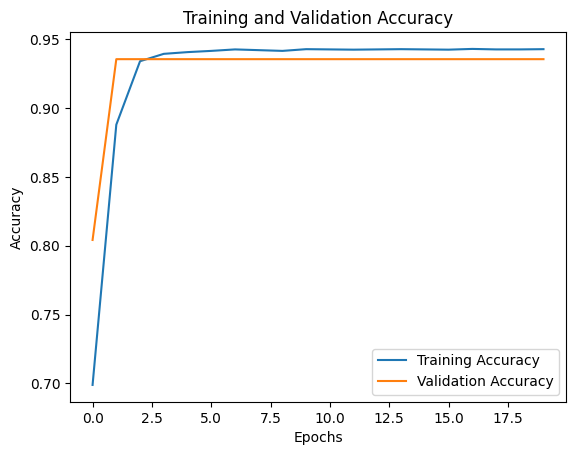

In [50]:
#encoder_model:
ad_model = train_model(X_train, y_train, epochs=20, batch_size=64, val_split=0.3, latent_space=latent_space)


In [51]:
ad_encoded_data = get_encoder_output(ad_model)
ad_encoder = get_encoder(get_encoder_input(ad_model), ad_encoded_data)


# Get the outputof last layer as a NumPy array
encoded_X_train = ad_encoder.predict(X_train)
encoded_X_test = ad_encoder.predict(X_test)

#split encoded data in normal and anomal data
normals_train = encoded_X_train[y2==1]
anomalies_train = encoded_X_train[y2==2]

250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [52]:
def orthogonal_projection_constraint(W_e, W_d, X):
    """ Compute the orthogonality constraint loss """
    X_T = tf.transpose(X)
    P_H1 = tf.matmul(X_T,tf.linalg.pinv(X_T))  # Projection operator
    P_approx = tf.matmul(W_e, W_d, transpose_a=True, transpose_b=True)  # Approximate projection operator
    return tf.norm(P_approx - P_H1)**2

class Autoencoder(Model):
    def __init__(self, input_dim, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = Dense(latent_dim, use_bias=False)
        self.decoder = Dense(input_dim, use_bias=False)

    def call(self, x):
        z = self.encoder(x)
        x_reconstructed = self.decoder(z)
        return x_reconstructed, z

def train_step(X_train, enc_X_train, decmodel):
    with tf.GradientTape() as tape:
        enc_X_reconstructed, Z = autoencoder(enc_X_train)
        pred_X = decmodel(enc_X_reconstructed)

        # Compute loss terms
        projection_loss = loss_fn(enc_X_train, enc_X_reconstructed)
        reconstruction_loss = loss_fn(X_train, pred_X)
        opc_loss = orthogonal_projection_constraint(autoencoder.encoder.weights[0],
                                                   autoencoder.decoder.weights[0], enc_X_train)

        loss = reconstruction_loss + lambda1 * projection_loss + lambda2 * opc_loss

    gradients = tape.gradient(loss, autoencoder.trainable_variables)
    optimizer.apply_gradients(zip(gradients, autoencoder.trainable_variables))
    return projection_loss,opc_loss,loss

In [53]:
# Hyperparameters
input_dim = encoded_X_train.shape[-1]  # Example input dimension
latent_dim = latent_space  # Latent space dimension
learning_rate = 0.01
lambda1 = 0.1
lambda2 = 0.4

# Initialize model, loss, optimizer
autoencoder = Autoencoder(input_dim, latent_dim)
optimizer = tf.keras.optimizers.Adam(learning_rate)
loss_fn = tf.keras.losses.MeanSquaredError()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,125 (12.21 KB)

 Trainable params: 3,125 (12.21 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 1.6861 - val_loss: 0.7974
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.9121 - val_loss: 0.7318
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8074 - val_loss: 0.6926
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7494 - val_loss: 0.6662
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7026 - val_loss: 0.6509
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6805 - val_loss: 0.6408
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6618 - val_loss: 0.6286
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6471 - val_loss: 0.6210
Epoch 9/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6298 - val_loss: 0.6055
Epoch 10/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6218 - val_loss: 0.5910
Epoch 11/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6082 - val_loss: 0.5696
Epoch 12/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5937 - val_l

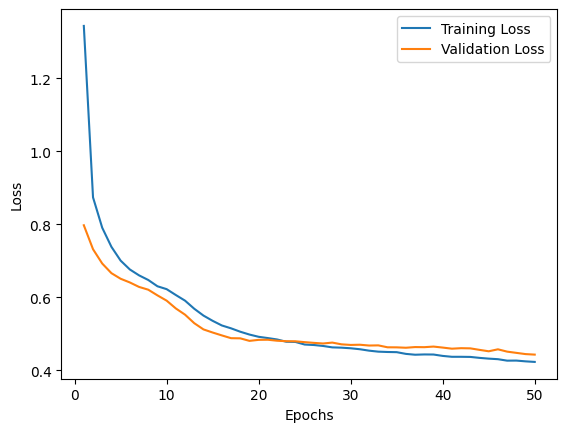

In [54]:
decmodel = train_decoder(X_train, encoded_X_train, epochs=50, batch_size=256, val_split=0.2)

In [55]:
# Training Loop
epochs = 25
batch_size = 256

x_train = normals_train
x_test = encoded_X_test

for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")

    # Shuffle training data for each epoch
    idx = np.random.permutation(len(x_train))
    x_train = encoded_X_train[idx]

    # Iterate through batches
    for i in range(0, len(x_train), batch_size):
        batch = x_train[i:i + batch_size]
        batch = tf.convert_to_tensor(batch, dtype=tf.float32)

        # Run a training step
        proj_loss, opc_loss, total_loss = train_step(X_train[y2==1],x_train, decmodel)
    #Print intermediate results
    print(f" \q Projection loss: {proj_loss.numpy():.3f}, OPC_loss: {opc_loss.numpy():.3f}, Total Loss = {total_loss.numpy():.3f}")


Epoch 1/25
 \q Projection loss: 39.837, OPC_loss: 7.177, Total Loss = 8.156
Epoch 2/25
 \q Projection loss: 17.039, OPC_loss: 4.454, Total Loss = 4.712
Epoch 3/25
 \q Projection loss: 7.379, OPC_loss: 3.089, Total Loss = 3.207
Epoch 4/25
 \q Projection loss: 2.772, OPC_loss: 2.317, Total Loss = 2.370
Epoch 5/25
 \q Projection loss: 1.565, OPC_loss: 1.816, Total Loss = 2.041
Epoch 6/25
 \q Projection loss: 1.410, OPC_loss: 1.427, Total Loss = 1.874
Epoch 7/25
 \q Projection loss: 1.350, OPC_loss: 1.110, Total Loss = 1.727
Epoch 8/25
 \q Projection loss: 1.323, OPC_loss: 0.875, Total Loss = 1.627
Epoch 9/25
 \q Projection loss: 1.290, OPC_loss: 0.699, Total Loss = 1.551
Epoch 10/25
 \q Projection loss: 1.249, OPC_loss: 0.556, Total Loss = 1.484
Epoch 11/25
 \q Projection loss: 1.235, OPC_loss: 0.449, Total Loss = 1.430
Epoch 12/25
 \q Projection loss: 1.221, OPC_loss: 0.367, Total Loss = 1.403
Epoch 13/25
 \q Projection loss: 1.214, OPC_loss: 0.303, Total Loss = 1.374
Epoch 14/25
 \q Pro

In [56]:
# After training, you can evaluate the model or detect anomalies similarly as before
reconstructed_test, Z = autoencoder.predict(x_test)
reconstructed_train, Z = autoencoder.predict(x_train)
mse_loss_datawise = np.mean(np.square(x_test - reconstructed_test), axis=1)
mse_loss_featurewise = np.mean(np.square(x_test - reconstructed_test), axis=0)

# Detect anomalies based on a threshold
threshold = np.percentile(mse_loss_datawise, 95)  # Example: top 5% of MSE values as anomalies
anomalies = mse_loss_datawise > threshold


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [57]:
#check if the neurons changed the most are actually important for the model
last_weights=ad_model.layers[-1].weights[0].value.numpy()
lw=(last_weights[np.argsort(-mse_loss_featurewise)]).flatten()

print("Neuron weights, change strength",np.round(np.stack((lw,np.sort(-mse_loss_featurewise)),axis=1),3))


Neuron weights, change strength [[ 0.087 -4.96 ]
 [ 0.089 -1.544]
 [ 0.265 -1.269]
 [-0.727 -0.913]
 [ 0.657 -0.206]
 [-0.659 -0.141]
 [ 0.483 -0.078]
 [ 0.41  -0.074]]


In [58]:
print("Anomalies detected:", ( mse_loss_datawise >( np.mean(mse_loss_datawise)+2*np.std(mse_loss_datawise))).sum())
print(f"Anomlies existing: {x_test[y2_test==2].shape[0]}")

print("Anomalies detected:", (mse_loss_datawise < ( np.mean(mse_loss_datawise)-2*np.std(mse_loss_datawise))).sum())
print(f"Anomlies existing: {x_test[y2_test==2].shape[0]}")

print(f"Mean, Std MSE anomal data. {np.mean(mse_loss_datawise[y2_test==2]):.3f}, {np.std(mse_loss_datawise[y2_test==2]):.3f}")
print(f"Mean, Std MSE normal data. {np.mean(mse_loss_datawise[y2_test==1]):.3f}, {np.std(mse_loss_datawise[y2_test==1]):.3f}")
print(f"Featurewise MSE loss: {[f'{x}: {y:.3f}' for x, y in zip(attributes, mse_loss_featurewise)]}")


Anomalies detected: 18
Anomlies existing: 1006
Anomalies detected: 0
Anomlies existing: 1006
Mean, Std MSE anomal data. 2.006, 0.551
Mean, Std MSE normal data. 0.280, 0.601
Featurewise MSE loss: ['compproxfeature1: 1.269', 'compproxfeature2: 0.206', 'corrfeature3: 4.960', 'randomfeature4: 0.074', 'randomfeature5: 0.913']


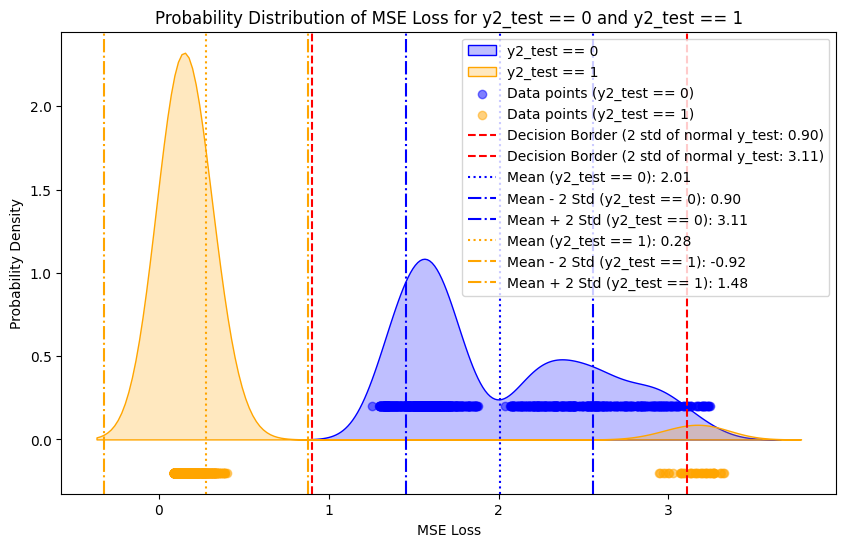

In [59]:
# Create a KDE for each class
kde_0 = gaussian_kde(mse_loss_datawise[y2_test == 2])
kde_1 = gaussian_kde(mse_loss_datawise[y2_test == 1])

# Create a range of values for the x-axis
x_values = np.linspace(min(mse_loss_datawise), max(mse_loss_datawise), 1000)

# Calculate the KDE values for each class
kde_values_0 = kde_0(x_values)
kde_values_1 = kde_1(x_values)

# Calculate mean and std for both distributions
mean_0, std_0 = np.mean(mse_loss_datawise[y2_test == 2]), np.std(mse_loss_datawise[y2_test == 2])
mean_1, std_1 = np.mean(mse_loss_datawise[y2_test == 1]), np.std(mse_loss_datawise[y2_test == 1])

# Plot the KDEs
plt.figure(figsize=(10, 6))
sns.kdeplot(mse_loss_datawise[y2_test == 2], label='y2_test == 0', fill=True, color='blue')
sns.kdeplot(mse_loss_datawise[y2_test == 1], label='y2_test == 1', fill=True, color='orange')

# Plot individual data points
plt.scatter(mse_loss_datawise[y2_test == 2], np.zeros_like(mse_loss_datawise[y2_test == 2]) + 0.2, color='blue', alpha=0.5, label='Data points (y2_test == 0)')
plt.scatter(mse_loss_datawise[y2_test == 1], np.zeros_like(mse_loss_datawise[y2_test == 1]) - 0.2, color='orange', alpha=0.5, label='Data points (y2_test == 1)')

# Calculate the decision border (2 std of mse_loss for y2_test == 0)
decision_border0 = mean_0 + 2 * std_0
decision_border2 = mean_0 - 2 * std_0

# Plot the decision border
plt.axvline(x=decision_border2, color='red', linestyle='--', label=f'Decision Border (2 std of normal y_test: {decision_border2:.2f})')
plt.axvline(x=decision_border0, color='red', linestyle='--', label=f'Decision Border (2 std of normal y_test: {decision_border0:.2f})')

# Plot mean and std lines for y2_test == 0
plt.axvline(x=mean_0, color='blue', linestyle=':', label=f'Mean (y2_test == 0): {mean_0:.2f}')
plt.axvline(x=mean_0 - std_0, color='blue', linestyle='-.', label=f'Mean - 2 Std (y2_test == 0): {mean_0 - 2*std_0:.2f}')
plt.axvline(x=mean_0 + std_0, color='blue', linestyle='-.', label=f'Mean + 2 Std (y2_test == 0): {mean_0 + 2*std_0:.2f}')

# Plot mean and std lines for y2_test == 1
plt.axvline(x=mean_1, color='orange', linestyle=':', label=f'Mean (y2_test == 1): {mean_1:.2f}')
plt.axvline(x=mean_1 - std_1, color='orange', linestyle='-.', label=f'Mean - 2 Std (y2_test == 1): {mean_1 - 2*std_1:.2f}')
plt.axvline(x=mean_1 + std_1, color='orange', linestyle='-.', label=f'Mean + 2 Std (y2_test == 1): {mean_1 + 2*std_1:.2f}')

# Add labels and legend
plt.xlabel('MSE Loss')
plt.ylabel('Probability Density')
plt.title('Probability Distribution of MSE Loss for y2_test == 0 and y2_test == 1')
plt.legend(loc='upper right')

# Show the plot
plt.show()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,125 (12.21 KB)

 Trainable params: 3,125 (12.21 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - loss: 3.6605 - val_loss: 1.0888
Epoch 2/25
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2299 - val_loss: 1.0686
Epoch 3/25
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1403 - val_loss: 1.0681
Epoch 4/25
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1057 - val_loss: 1.0610
Epoch 5/25
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0726 - val_loss: 1.0558
Epoch 6/25
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0748 - val_loss: 1.0594
Epoch 7/25
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0627 - val_loss: 1.0544
Epoch 8/25
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0607 - val_loss: 1.0570
Epoch 9/25
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0542 - val_loss: 1.0530
Epoch 10/25
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0454 - val_loss: 1.0532
Epoch 11/25
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0432 - val_loss: 1.0489
Epoch 12/25
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0455 - val_l

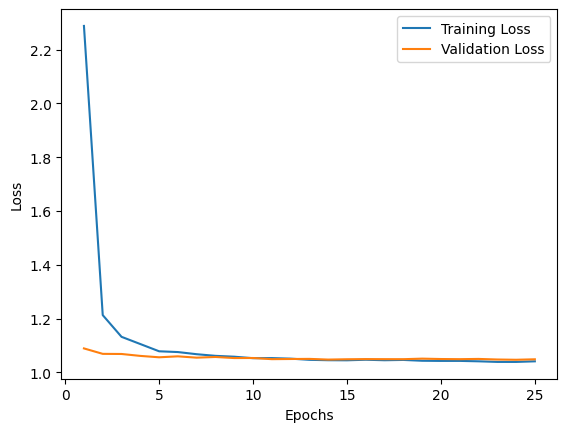

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [60]:
decoder_ad=train_decoder(X_train[y2==1],reconstructed_train, epochs=25, val_split=0.2)
reconstructed_X_test_ad = decoder_ad.predict(reconstructed_test)


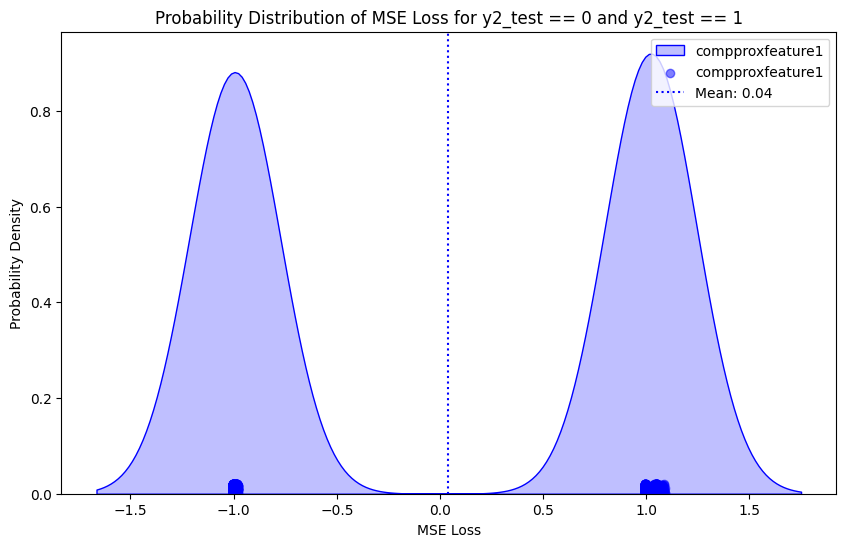

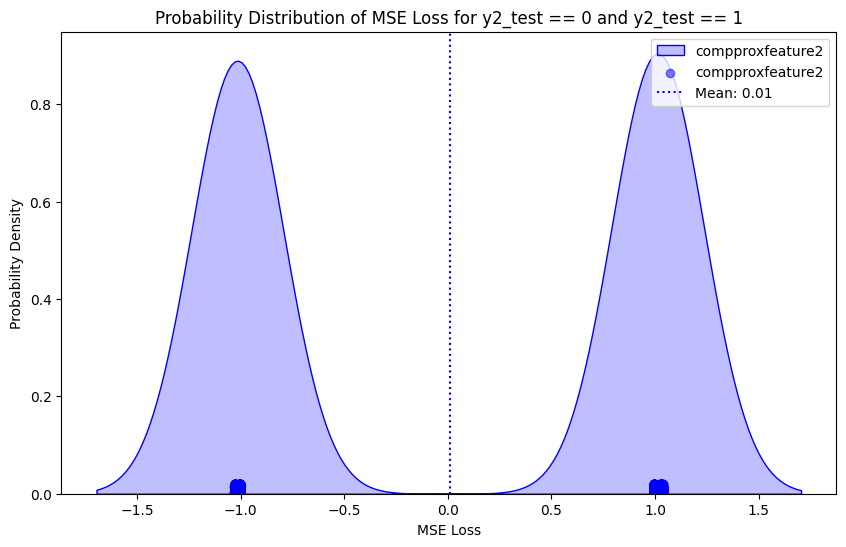

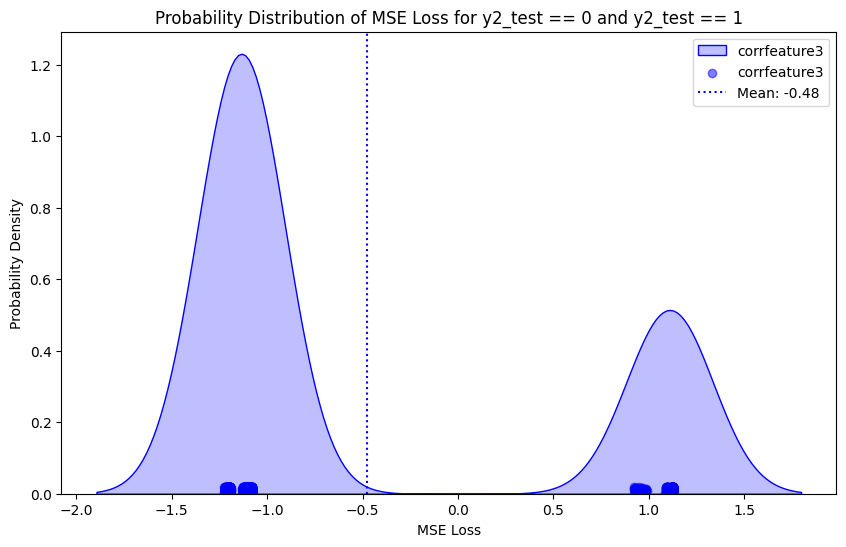

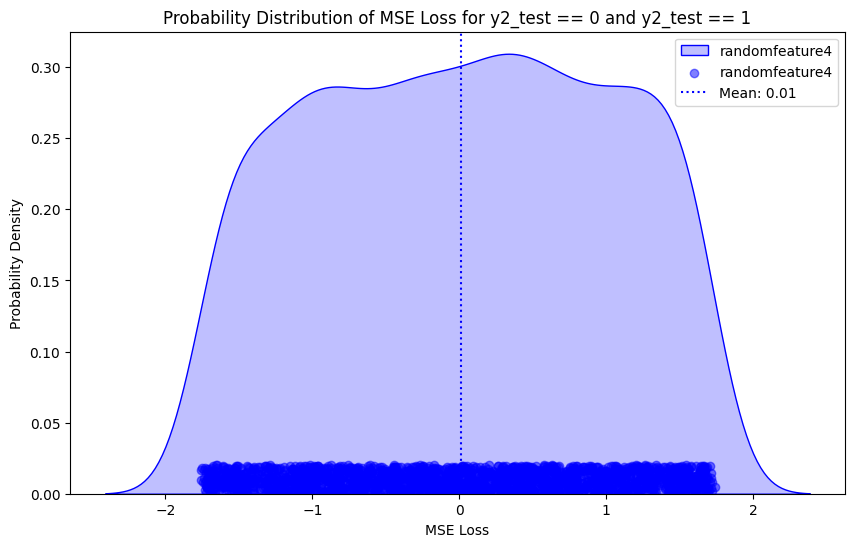

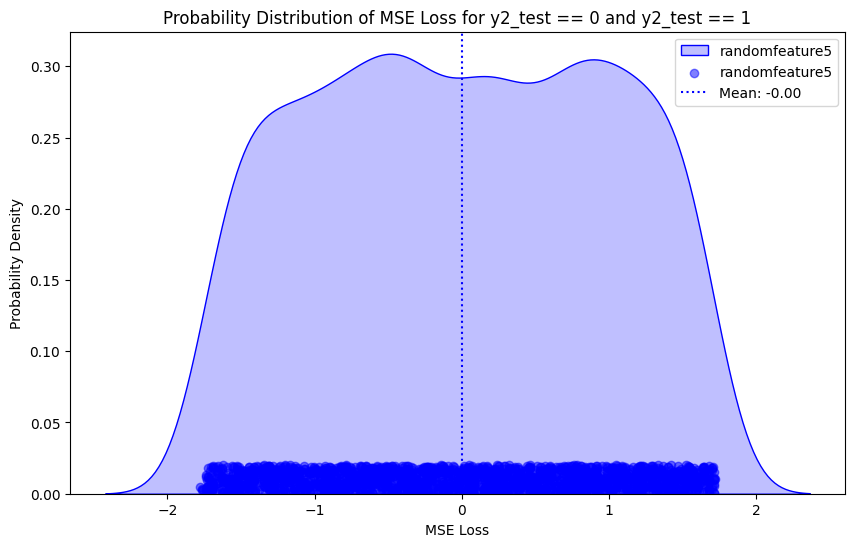

In [61]:
quad_diffs= (reconstructed_X_test_ad-X_test)
for i in range(X_test.shape[1]):

    #KDEs
    kde_0 = gaussian_kde(quad_diffs[:,i])
    kde_values_0 = kde_0(x_values)

    x_values = np.linspace(np.min(quad_diffs), np.max(quad_diffs), 1000)

    mean_0, std_0 = np.mean(quad_diffs[:,i]), np.std(quad_diffs[:,i])

    # Plotting
    plt.figure(figsize=(10, 6))
    sns.kdeplot(quad_diffs[:,i], label=attributes[i], fill=True, color='blue')
    jitter=np.random.random_sample(size=X_test.shape[0])*0.02
    plt.scatter(quad_diffs[:,i], np.zeros_like(quad_diffs[:,i]) + jitter, color='blue', alpha=0.5, label=attributes[i])
    plt.axvline(x=mean_0, color='blue', linestyle=':', label=f'Mean: {mean_0:.2f}')

    plt.xlabel('MSE Loss')
    plt.ylabel('Probability Density')
    plt.title('Probability Distribution of MSE Loss for y2_test == 0 and y2_test == 1')
    plt.legend(loc='upper right')

plt.show()

In [62]:
for x in range(attributes.shape[0]):
  print( f"{attributes[np.argsort(-np.mean(quad_diffs, axis=0))][x]} differs from original by {-np.sort(-np.mean(quad_diffs, axis=0))[x]:.3f}")


compproxfeature1 differs from original by 0.039
randomfeature4 differs from original by 0.014
compproxfeature2 differs from original by 0.008
randomfeature5 differs from original by -0.002
corrfeature3 differs from original by -0.478


# AD baseline

In [63]:
# Initialize model, loss, optimizer
autoencoder = Autoencoder(input_dim, latent_dim)
optimizer = tf.keras.optimizers.Adam(learning_rate)
loss_fn = tf.keras.losses.MeanSquaredError()

In [64]:
# Training Loop
x_train = encoded_X_train
x_test = encoded_X_test
epochs = 20
batch_size = 256
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")

    #randomizing
    idx = np.random.permutation(len(x_train))
    x_train = encoded_X_train[idx]

    for i in range(0, len(x_train), batch_size):
        batch = x_train[i:i + batch_size]
        batch = tf.convert_to_tensor(batch, dtype=tf.float32)

        # Training step
        proje_loss, opc_loss, total_loss = train_step(X_train,x_train,decmodel)

    print(f"Projection loss: {proj_loss.numpy():.3f}, OPC_loss: {opc_loss.numpy():.4f}, Total Loss = {total_loss.numpy():.4f}")

Epoch 1/20
Projection loss: 1.139, OPC_loss: 2.9805, Total Loss = 2.6926
Epoch 2/20
Projection loss: 1.139, OPC_loss: 1.2148, Total Loss = 1.7312
Epoch 3/20
Projection loss: 1.139, OPC_loss: 0.3323, Total Loss = 1.3606
Epoch 4/20
Projection loss: 1.139, OPC_loss: 0.1071, Total Loss = 1.2694
Epoch 5/20
Projection loss: 1.139, OPC_loss: 0.0483, Total Loss = 1.2428
Epoch 6/20
Projection loss: 1.139, OPC_loss: 0.0290, Total Loss = 1.2263
Epoch 7/20
Projection loss: 1.139, OPC_loss: 0.0216, Total Loss = 1.2176
Epoch 8/20
Projection loss: 1.139, OPC_loss: 0.0208, Total Loss = 1.2114
Epoch 9/20
Projection loss: 1.139, OPC_loss: 0.0142, Total Loss = 1.2004
Epoch 10/20
Projection loss: 1.139, OPC_loss: 0.0130, Total Loss = 1.2108
Epoch 11/20
Projection loss: 1.139, OPC_loss: 0.0137, Total Loss = 1.2099
Epoch 12/20
Projection loss: 1.139, OPC_loss: 0.0129, Total Loss = 1.1906
Epoch 13/20
Projection loss: 1.139, OPC_loss: 0.0112, Total Loss = 1.1878
Epoch 14/20
Projection loss: 1.139, OPC_loss: 0

In [65]:
reconstructed_test_base, Z = autoencoder.predict(x_test)
reconstructed_train_base, Z = autoencoder.predict(x_train)
mse_loss_datawise_base = np.mean(np.square(x_test - reconstructed_test), axis=1)
mse_loss_featurewise_base = np.mean(np.square(x_test - reconstructed_test), axis=0)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,125 (12.21 KB)

 Trainable params: 3,125 (12.21 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 5.2752 - val_loss: 1.0482
Epoch 2/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.2601 - val_loss: 1.0270
Epoch 3/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1237 - val_loss: 1.0212
Epoch 4/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0737 - val_loss: 1.0196
Epoch 5/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0577 - val_loss: 1.0140
Epoch 6/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0373 - val_loss: 1.0134
Epoch 7/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0288 - val_loss: 1.0142
Epoch 8/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0253 - val_loss: 1.0133
Epoch 9/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0192 - val_loss: 1.0138
Epoch 10/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0181 - val_loss: 1.0130
Epoch 11/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0108 - val_loss: 1.0123
Epoch 12/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

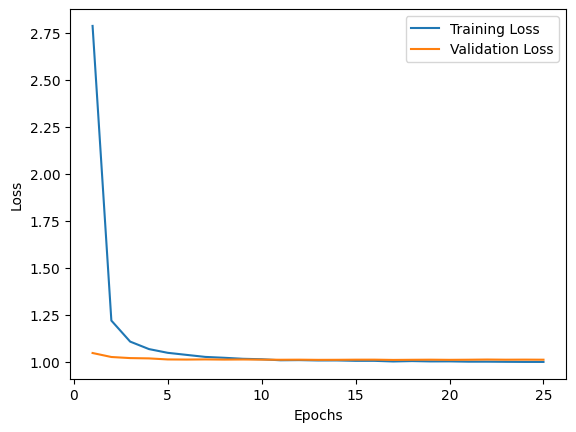

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [66]:
decoder_ad_base=train_decoder(X_train,reconstructed_train_base, epochs=25)
reconstructed_X_test_ad_base = decmodel.predict(x_test)
reconstructed_X_test_ad_base2 = decoder_ad_base.predict(reconstructed_test_base)

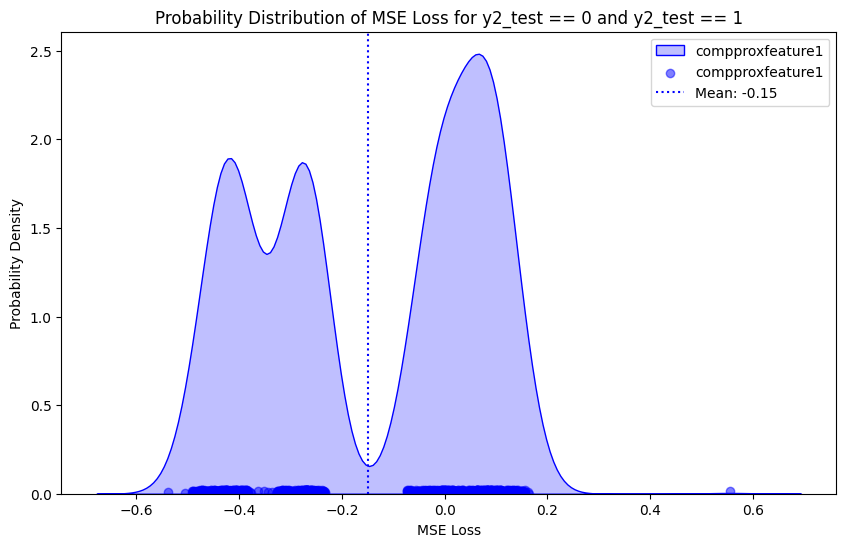

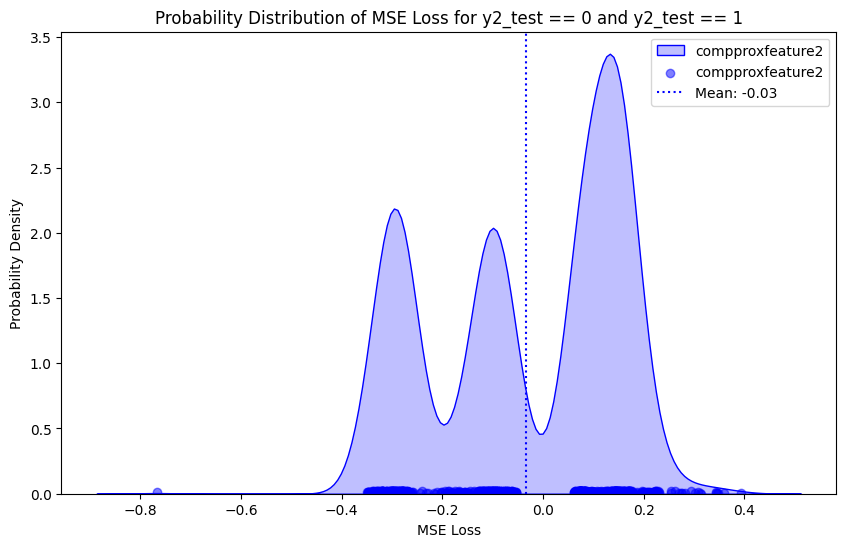

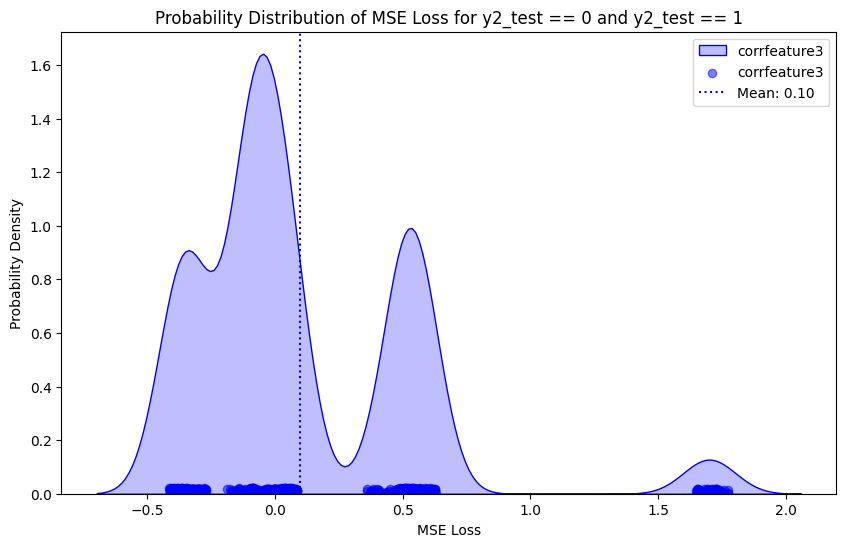

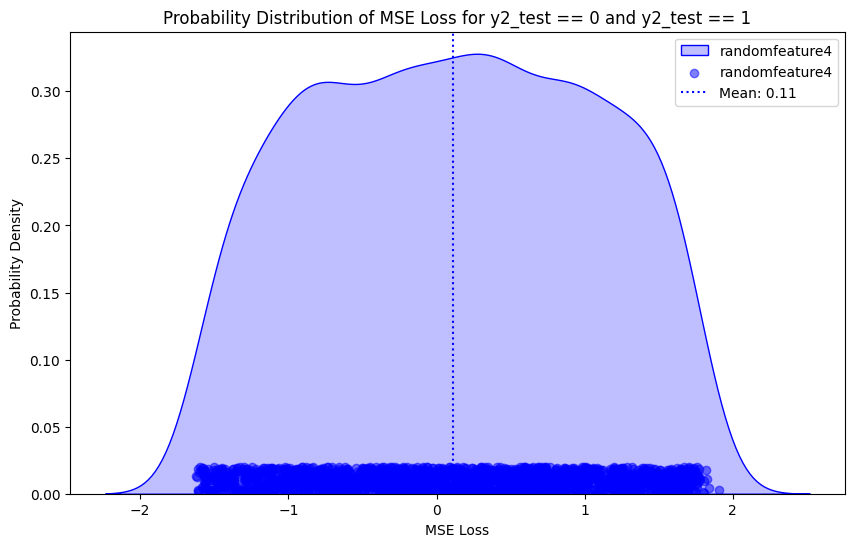

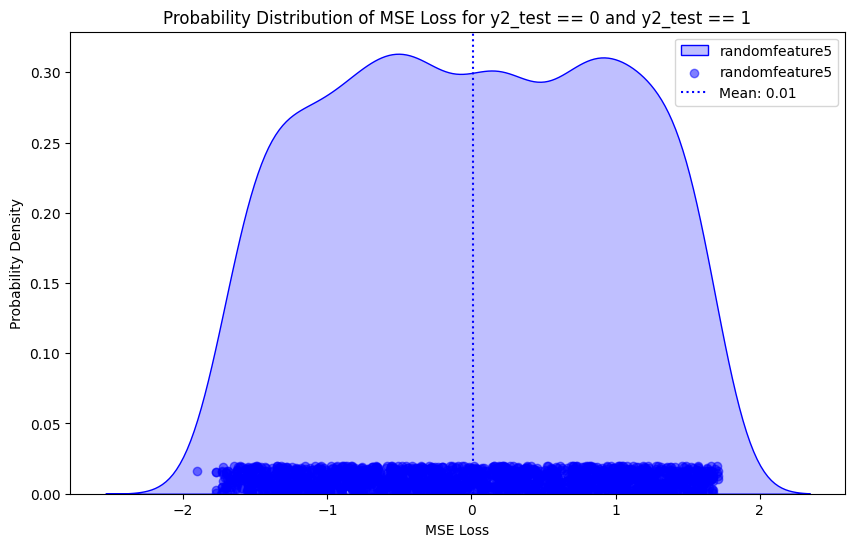

In [67]:
quad_diffs_base=reconstructed_X_test_ad_base-X_test
for i in range(X_test.shape[1]):

    # Create KDEs
    kde_0 = gaussian_kde(quad_diffs_base[:,i])
    kde_values_0 = kde_0(x_values)

    x_values = np.linspace(np.min(quad_diffs_base), np.max(quad_diffs_base), 1000)


    mean_0, std_0 = np.mean(quad_diffs_base[:,i]), np.std(quad_diffs_base[:,i])

    # Plotting
    plt.figure(figsize=(10, 6))
    sns.kdeplot(quad_diffs_base[:,i], label=attributes[i], fill=True, color='blue')

    jitter=np.random.random_sample(size=X_test.shape[0])*0.02
    plt.scatter(quad_diffs_base[:,i], np.zeros_like(quad_diffs_base[:,i]) + jitter, color='blue', alpha=0.5, label=attributes[i])

    plt.axvline(x=mean_0, color='blue', linestyle=':', label=f'Mean: {mean_0:.2f}')

    plt.xlabel('MSE Loss')
    plt.ylabel('Probability Density')
    plt.title('Probability Distribution of MSE Loss for y2_test == 0 and y2_test == 1')
    plt.legend(loc='upper right')

plt.show()

In [68]:
quad_diffs_base.shape

(2000, 5)

In [69]:
for x in range(attributes.shape[0]):
  print( f"{attributes[np.argsort(-np.mean(quad_diffs_base, axis=0))][x]} differs from original by {-np.sort(-np.mean(quad_diffs_base, axis=0))[x]:.3f}")



randomfeature4 differs from original by 0.113
corrfeature3 differs from original by 0.098
randomfeature5 differs from original by 0.008
compproxfeature2 differs from original by -0.034
compproxfeature1 differs from original by -0.148


#Comparison baseline vs sensitive AD

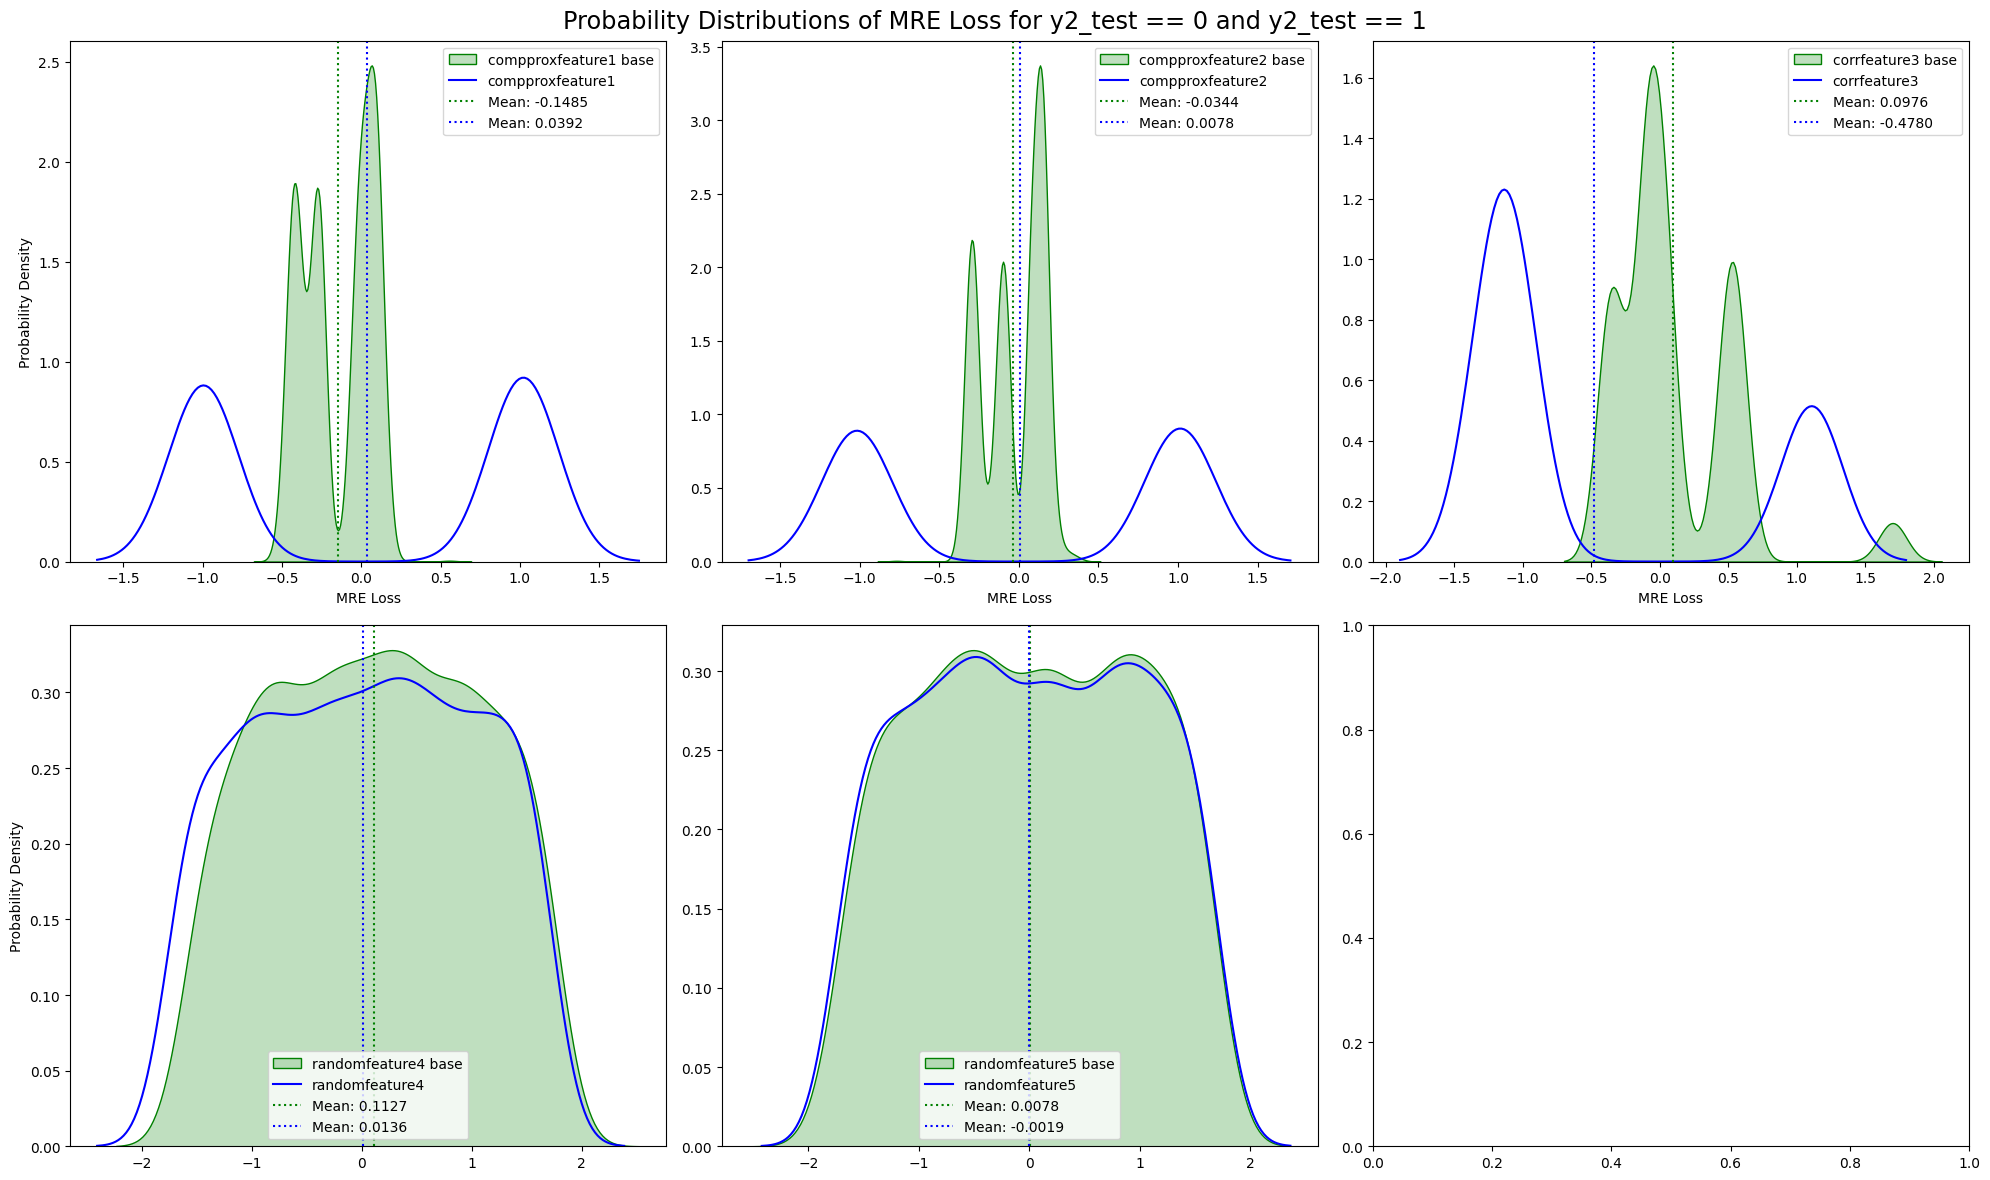

In [70]:
quad_diffs=quad_diffs
quad_diffs_base=quad_diffs_base
t=3
fig, ax = plt.subplots(len(attributes)//t+1,t, figsize=(20,12))
for i in range(X_test.shape[1]):
    # Create KDEs
    kde_0 = gaussian_kde(quad_diffs_base[:,i])
    kde_2 = gaussian_kde(quad_diffs[:,i])
    kde_values_0 = kde_0(x_values)
    kde_values_2 = kde_2(x_values)

    x_values = np.linspace(np.min((quad_diffs,quad_diffs_base)), np.max((quad_diffs,quad_diffs_base)), 1000)

    mean_0, std_0 = np.mean(quad_diffs_base[:,i]), np.std(quad_diffs_base[:,i])
    mean_2, std_2 = np.mean(quad_diffs[:,i]), np.std(quad_diffs[:,i])

    # Plotting
    sns.kdeplot(quad_diffs_base[:,i], label=f"{attributes[i]} base", ax=ax[i//t,i%t], fill=True, color='green')
    sns.kdeplot(quad_diffs[:,i], label=attributes[i], ax=ax[i//t,i%t], fill=False, color='blue')

    jitter=np.random.random_sample(size=X_test.shape[0])*0.03
    jitter2=np.random.random_sample(size=X_test.shape[0])*0.03

    ax[i//t,i%t].axvline(x=mean_0, color='green', linestyle=':', label=f'Mean: {mean_0:.4f}')
    ax[i//t,i%t].axvline(x=mean_2, color='blue', linestyle=':', label=f'Mean: {mean_2:.4f}')

    if i%t==0:
      ax[i//t,i%t].set_ylabel('Probability Density')
    else:
      ax[i//t,i%t].set_ylabel('')
    if i//t==0:
      ax[i//t,i%t].set_xlabel('MRE Loss')
    ax[i//t,i%t].legend()

fig.suptitle('Probability Distributions of MRE Loss for y2_test == 0 and y2_test == 1',fontsize='xx-large')
fig.tight_layout()
plt.savefig(f'ad_comparison_{name}')
plt.show()

In [71]:
for x in range(attributes.shape[0]):
  print(f"{attributes[np.argsort(-np.mean(quad_diffs-quad_diffs_base,axis=0))][x]} reconstruction difference is on average: {-np.sort(-np.mean(quad_diffs-quad_diffs_base, axis=0))[x]:.3f}")



compproxfeature1 reconstruction difference is on average: 0.188
compproxfeature2 reconstruction difference is on average: 0.042
randomfeature5 reconstruction difference is on average: -0.010
randomfeature4 reconstruction difference is on average: -0.099
corrfeature3 reconstruction difference is on average: -0.576
